# Building XGBoostClassifer models

This notebook:
* builds several XGBoostClassifier models to experiment with performance in response to different formats of input data
* rebuilds the 2nd and 3rd GridSearchCV "best_params_" models which were both run on a GPU from Google Colab (for the 3rd Grid Search run, see associated file `erwait_model_xgboost_GridSearch3rdrun_Google_Colab.ipynb` which was executed on Colab) to utilize the hyperparameters for an XGBoostClassifer

In [124]:
# # For portions of this notebook that ran on Google Colab for the GPU - Uncomment to use on Colab
# import sys
# sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/src')

# from google.colab import drive
# drive.mount('/content/gdrive')

In [125]:
from modules.utility import Utility
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as IMBPipeline

import pickle

In [126]:
# # Uncomment code as required to force reload utility.py
# # Was only required during development of this notebook

# from importlib import reload
# import modules.utility
# reload(modules.utility)
# from modules.utility import Utility

# Setup

Remove display limits for column and row lengths, for easier viewing of dataframes

In [127]:
# Set no limits for number of columns and rows to display
# Utility.reset_display_max_cols_rows() to reset
Utility.setup_display_max_cols_rows()

Load the cleaned data

In [128]:
# Load the final, melted, cleaned dataset
df = Utility.get_clean_waittimes_dataframe()
df.head()

,datetime,hospital,waittime,year,dayofweek,numdayofweek,weekofyear,hour,dayperiod,id,services,city,cityarea,citypop,citytype,hosplat,hosplong
0,2022-09-24 18:22:00,Alberta Children's Hospital,201.0,2022,Saturday,5,38,18,evening,ach,emergency,Calgary,826,1306784,urban,51.074759,-114.146833
1,2022-09-24 18:22:00,Chinook Regional Hospital,69.0,2022,Saturday,5,38,18,evening,crh,emergency,Lethbridge,122,98406,peri,49.685221,-112.816209
2,2022-09-24 18:22:00,Devon General Hospital,132.0,2022,Saturday,5,38,18,evening,dgh,emergency,Devon,14,6545,rural,53.352265,-113.728288
3,2022-09-24 18:22:00,Foothills Medical Centre,188.0,2022,Saturday,5,38,18,evening,fmc,emergency,Calgary,826,1306784,urban,51.064657,-114.130926
4,2022-09-24 18:22:00,Fort Sask Community Hospital,295.0,2022,Saturday,5,38,18,evening,fsch,emergency,Fort Saskatchewan,48,27088,rural,53.693175,-113.213436


In [129]:
# Original df shape
df.shape

(201151, 17)

Remove 'Urgent Care' facilities so we are only modelling on ERs

In [130]:
# Filter the dataframe to be only Emergency services
ER_SERVICES_MASK = Utility.MASK_EMERGENCY_SERVICES(df)
df = df[ER_SERVICES_MASK]

In [131]:
# df shape after dropping 'urgentcare' services
df.shape

(181926, 17)

# Prepare data for modeling

Try a logistic regression classification learning model where y = binary outcome of long wait, where I have **defined long wait as "greater than 400 minutes (6.67 hours)"**.

This '400 minute' choice was based on the following:
* Looking at the descriptive statistics for the entire dataset or ER hospitals
* Calculating the upper bound for outliers (`Q3 + IQR*1.5`) cut off for ER hospitals (500 minutes)
* The following national guidelines, with images shown in readme.md:
    - Canadian ED Triage & Acuity Scale, 1998: https://ctas-phctas.ca/wp-content/uploads/2018/05/ctased16_98.pdf
        - Specifying lowest triage level (Level V) should have time to physician <= 2 hours
    - CAEP (Canadian Associate of Emergency Physicians) Position Statement, 2013: "Emergency department overcrowding and access block":  https://caep.ca/wp-content/uploads/2016/03/cjem_2013_overcrowding_and_access_block.pdf
        - Specifying recommendation for median 1 hour to PIA and 3 hours at 90% percentile
    - Alberta Health Performance Measure Definition for TPIA (Time to Physician Initial Assessment) (Feb 2015): https://open.alberta.ca/dataset/c7e3fc16-7aea-455c-96a1-20811a640b1a/resource/e2f49c22-3390-48a3-ac74-278a932aa668/download/pmd-ed-time-physician-initial-assessment.pdf
        - Specifying national sides averaging 3.2 hours, Alberta sites averaging 3.1 hours (in 2012-13)
    - "Physician Initial Assessment Times Based on CTAS Scores: Are We Meeting the Recommendations?": https://www.longwoods.com/content/26333/healthcare-quarterly/physician-initial-assessment-times-based-on-ctas-scores-are-we-meeting-the-recommendations-
        - Specifying "overall compliance with recommended PIA times was low" in 4 community EDs around Hamilton, Ontario from 2016-2017.


Feature Engineer:
* longwait: 0 or 1

Drop:
* datetime
* hospital (we will use 'id' instead)
* waittime (we are using our binary value of 'longwait' instead, because this is a classification problem)
* year
* numdayofweek (we will use 'dayofweek' instead)
* services (they are all 'emergency' based on our earlier filter)
* cityarea
* citypop
* hosplat
* hosplong

We will also do additional feature engineering to simplify features:
* collapse citytype 'peri' into 'rural', and keep this feature

**NOTE: I have defined constants and utility functions in the `Utility` class in `modules.utility` (modules/utility.py file) to ensure consistency in shaping the dataframe that is ultimately used for modelling, in each classifier I build.**

In [132]:
# Create new dataframe called df_model
df_model = df.copy()

# Collapse citytype 'peri' into 'rural'.  This is a valid assumption as demonstrated by plots in the erwait_eda_hypothesis_testing.ipynb notebook.
Utility.collapse_periurban_to_rural(df_model)

# Engineer the new feature 'longwait'
Utility.add_longwait_feature(df_model)

# Drop unwanted columns, which are defined as Utility.LOGIT_DROP_COLS, for consistent use in every notebook for every classification model.
Utility.drop_unwanted_columns(df_model, Utility.LOGIT_DROP_COLS)

Confirm how the dataframe looks after:
* Collapsing peri to rural
* Adding the 'longwait' feature (this will be our target variable)
* Dropping unwanted columns/features

In [133]:
Utility.display_df_general_info(df_model)
# display(df_model.head())
# print(f"\nShape of df_model: {df_model.shape}")
# print(f"\nColumns of df_model: {df_model.columns}")
# print(f"\ndtypes of df_model: {df_model.dtypes}")

,dayofweek,weekofyear,hour,dayperiod,id,city,citytype,longwait
0,Saturday,38,18,evening,ach,Calgary,urban,0
1,Saturday,38,18,evening,crh,Lethbridge,rural,0
2,Saturday,38,18,evening,dgh,Devon,rural,0
3,Saturday,38,18,evening,fmc,Calgary,urban,0
4,Saturday,38,18,evening,fsch,Fort Saskatchewan,rural,0



Shape of dataframe:
(181926, 8)

Columns of dataframe:
Index(['dayofweek', 'weekofyear', 'hour', 'dayperiod', 'id', 'city',
       'citytype', 'longwait'],
      dtype='object')

dtypes of dataframe:
dayofweek     object
weekofyear     int64
hour           int64
dayperiod     object
id            object
city          object
citytype      object
longwait       int64
dtype: object


Sort the dataframe a consistent and particular way (as defined in Utility class) prior to one-hot encoding, so that the one-hot encoding is consistent across all notebooks for all classification models.

In [134]:
df_model = Utility.sort_df_before_encoding_or_modeling(df_model)

Check what it looks like after sorting


In [135]:
df_model.head()

,dayofweek,weekofyear,hour,dayperiod,id,city,citytype,longwait
0,Friday,1,0,night,ach,Calgary,urban,0
1,Friday,1,0,night,crh,Lethbridge,rural,0
2,Friday,1,0,night,dgh,Devon,rural,0
3,Friday,1,0,night,fmc,Calgary,urban,1
4,Friday,1,0,night,fsch,Fort Saskatchewan,rural,0


# BRANCH FOR DIFFERENT MODELS AT THIS POINT.
AT THIS POINT IN THE NOTEBOOK, THE FOUNDATIONAL DATA SETUP THAT IS SHARED BY THE MODELS FOLLOWING, HAS BEEN SETUP.

BRANCH HERE

# Modelling Plans

We will build 6 simple XGBoost Forest models and compare results as follows, to see what type of input data works best with this type of model, before improving with GridSearchCV and hyperparameter choices near the end of this notebook.

We built an additional 7th model as a result of our evaluation of the first 6 models, and that is included in this table for completeness.



| Model   Name                              | Feature Columns                                                                                                                            | Target Column | One-Hot Encoded Columns                                                                                    | Label Encoded Columns                                                                 | Names of columns not one-hot   encoded           | Datatypes of non-one-hot-encoded   columns   | Class Counts                                                                                                                                                                              | Main Question                                                                                                                                                                                                                                                                                                                                                                   |
|-------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------|---------------|------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------|--------------------------------------------------|----------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| baseline                                  | 'dayofweek', 'weekofyear', 'hour', 'dayperiod', 'id', 'city', 'citytype'                                                                   | 'longwait'    | Utility.LOGIT_ONEHOT_COLS_A:      'dayofweek', 'dayperiod', 'id', 'city', 'citytype'                       | None                                                                                  | 'weekofyear', 'hour'                             | 'hour': category      'weekofyear': category | Imbalanced: '1': 93.3%, '0': 6.7%, scale_pos_weight set appropriately                                                                                                                     | What is baseline performance for basic XGBoostClassifier model?                                                                                                                                                                                                                                                                                                                 |
| onehot                                    | 'dayofweek', 'weekofyear', 'hour', 'dayperiod', 'id', 'city', 'citytype'                                                                   | 'longwait'    | Utility.RFC_ONEHOT_COLS_ALL:      'dayofweek', 'weekofyear', 'hour', 'dayperiod', 'id', 'city', 'citytype' | None                                                                                  | N/A                                              | N/A                                          | Imbalanced: '1': 93.3%, '0': 6.7%, scale_pos_weight set appropriately                                                                                                                     | What is performance when all features one-hot encoded?                                                                                                                                                                                                                                                                                                                          |
| onehot_dropdayperiod                      | 'dayofweek', 'weekofyear', 'hour', 'dayperiod', 'id', 'city', 'citytype'                                                                   | 'longwait'    |      'dayofweek', 'weekofyear', 'hour', 'id', 'city', 'citytype'                                           | None                                                                                  | N/A                                              | N/A                                          | Imbalanced: '1': 93.3%, '0': 6.7%, scale_pos_weight set appropriately                                                                                                                     | What is performance when 'dayperiod' (column that is collinear with   'hour' ) is dropped, but every column is otherwise one-hot encoded?                                                                                                                                                                                                                                       |
| labelencoded                              | Remove 'dayperiod' from columns,   as it is collinear:      Resulting cols = 'dayofweek', 'weekofyear', 'hour', 'id', 'city',   'citytype' | 'longwait'    | None                                                                                                       | All feature columns:      'dayofweek', 'weekofyear', 'hour', 'id', 'city', 'citytype' | All feature columns are label encoded            | int64 via Label Encoding                     | Imbalanced: '1': 93.3%, '0': 6.7%, scale_pos_weight set appropriately                                                                                                                     | Does making all features Label Encoded and thereby reducing   dimensionality (and also removing removing the 'dayperiod' which is   multicollinear with 'hour'), increase performance?                                                                                                                                                                                          |
| labelpartial                              | 'dayofweek', 'weekofyear', 'hour', 'dayperiod', 'id', 'city', 'citytype'                                                                   | 'longwait'    | Utility.LOGIT_ONEHOT_COLS_A:      'dayofweek', 'dayperiod', 'id', 'city', 'citytype'                       | 'dayofweek', 'weekofyear'                                                             | Label encoded columns: 'dayofweek', 'weekofyear' | int64 via Label Encoding                     | Imbalanced: '1': 93.3%, '0': 6.7%, scale_pos_weight set appropriately                                                                                                                     | Does reintroducing one-hot encoding for most columns, but making   'weekofyear' and 'hour' label encoded (partial reduction of dimensionality)   increase performance?                                                                                                                                                                                                          |
| labepartialsmote                          | Same as label partial, but with SMOTE applied (sampling_strategy of 0.1)   and RandomUnderSampler applied (sampling_strategy of 0.4).      | 'longwait'    | Utility.LOGIT_ONEHOT_COLS_A:      'dayofweek', 'dayperiod', 'id', 'city', 'citytype'                       | 'dayofweek', 'weekofyear'                                                             | Label encoded columns: 'dayofweek', 'weekofyear' | int64 via Label Encoding                     | Apply SMOTE at sampling_strategy=0.1, and RandomUnderSampler at   sampling_strategy=0.5. Slightly less imbalanced: '1': 66.67%, '0':   33.33%,.  Do not use scale_pos_weight   parameter. | Does over and undersampling to balance classes, without using   scale_pos_weight, and using the data format with the best overall results   (labelpartial) increase performance?                                                                                                                                                                                                |
| baselinesmote      (7th additional model) | 'dayofweek', 'weekofyear', 'hour', 'dayperiod', 'id', 'city', 'citytype'                                                                   | 'longwait'    | Utility.LOGIT_ONEHOT_COLS_A:      'dayofweek', 'dayperiod', 'id', 'city', 'citytype'                       | None                                                                                  | 'weekofyear', 'hour'                             | 'hour': category      'weekofyear': category | Apply SMOTE at sampling_strategy=0.1, and RandomUnderSampler at   sampling_strategy=0.5. Slightly less imbalanced: '1': 66.67%, '0':   33.33%,.  Do not use scale_pos_weight   parameter. | Can we get better scores by applying SMOTE/UnderSampler, on the Baseline   data treatment, since the Encoded models didn't seem to perform better than   Baseline data treatment.  (In Baseline:   most variables one-hot encoded, but 'hour' and 'weekofyear' variables set to   categorical with enable_categorical=True set for model)? This will simplify   data treatment. |

## Build XGBoost model: "baseline"

In [136]:
# One-hot encoding of categorical columns as defined in Utility function (LOGIT_ONEHOT_COLS_A includes 'dayperiod')
df_model_onehot_cols_a = Utility.one_hot_encode_categorical_columns(df_model, Utility.LOGIT_ONEHOT_COLS_A)

# Turn booleans into 0's and 1'
Utility.convert_booleans(df_model_onehot_cols_a)

Convert 'hour' and 'weekofyear' to category types

In [137]:
df_model_onehot_cols_a['hour'] = df_model_onehot_cols_a['hour'].astype('category')
df_model_onehot_cols_a['weekofyear'] = df_model_onehot_cols_a['weekofyear'].astype('category')

How does the dataframe look?

In [138]:
Utility.display_df_general_info(df_model_onehot_cols_a)

,weekofyear,hour,longwait,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,dayperiod_evening,dayperiod_night,id_crh,id_dgh,id_fmc,id_fsch,id_gnch,id_lch,id_mch,id_mhrh,id_nchc,id_plc,id_rah,id_rdrh,id_rgh,id_sch,id_schc,id_shc,id_stollery,id_uah,id_whc,city_Devon,city_Edmonton,city_Fort Saskatchewan,city_Leduc,city_Lethbridge,city_Medicine Hat,city_Red Deer,city_Sherwood Park,city_St. Albert,city_Stony Plain,citytype_urban
0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0



Shape of dataframe:
(181926, 41)

Columns of dataframe:
Index(['weekofyear', 'hour', 'longwait', 'dayofweek_Monday',
       'dayofweek_Saturday', 'dayofweek_Sunday', 'dayofweek_Thursday',
       'dayofweek_Tuesday', 'dayofweek_Wednesday', 'dayperiod_evening',
       'dayperiod_night', 'id_crh', 'id_dgh', 'id_fmc', 'id_fsch', 'id_gnch',
       'id_lch', 'id_mch', 'id_mhrh', 'id_nchc', 'id_plc', 'id_rah', 'id_rdrh',
       'id_rgh', 'id_sch', 'id_schc', 'id_shc', 'id_stollery', 'id_uah',
       'id_whc', 'city_Devon', 'city_Edmonton', 'city_Fort Saskatchewan',
       'city_Leduc', 'city_Lethbridge', 'city_Medicine Hat', 'city_Red Deer',
       'city_Sherwood Park', 'city_St. Albert', 'city_Stony Plain',
       'citytype_urban'],
      dtype='object')

dtypes of dataframe:
weekofyear                category
hour                      category
longwait                     int64
dayofweek_Monday             int32
dayofweek_Saturday           int32
dayofweek_Sunday             int32
dayofwee

## Set X and y dataframes for "baseline" model

In [139]:
X_model = (df_model_onehot_cols_a.drop(['longwait'], axis=1))
y_model = (df_model_onehot_cols_a['longwait'])

## Train-Test Split for Model: "baseline"

In [140]:
# Make 80% training, 20% testing and shuffle the data
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=Utility.RANDOM_STATE_CONST, shuffle=True)

In [141]:
# Check what are the types and numbers in each of the 6 items I just created:
print(f"type(X_model): {type(X_model)}")
print(f"type(y_model): {type(y_model)}")

print(f"type(X_train): {type(X_train)}")
print(f"type(y_train): {type(y_train)}")

print(f"type(X_test): {type(X_test)}")
print(f"type(y_test): {type(y_test)}")

print(f"X_model.shape[0]: {X_model.shape[0]}")
print(f"y_model.shape[0]: {y_model.shape[0]}")

print(f"X_train.shape[0]: {X_train.shape[0]}")
print(f"y_train.shape[0]: {y_train.shape[0]}")

print(f"X_test.shape[0]: {X_test.shape[0]}")
print(f"y_test.shape[0]: {y_test.shape[0]}")

type(X_model): <class 'pandas.core.frame.DataFrame'>
type(y_model): <class 'pandas.core.series.Series'>
type(X_train): <class 'pandas.core.frame.DataFrame'>
type(y_train): <class 'pandas.core.series.Series'>
type(X_test): <class 'pandas.core.frame.DataFrame'>
type(y_test): <class 'pandas.core.series.Series'>
X_model.shape[0]: 181926
y_model.shape[0]: 181926
X_train.shape[0]: 145540
y_train.shape[0]: 145540
X_test.shape[0]: 36386
y_test.shape[0]: 36386


Check class distributions in y_train and y_test after the train_test_split.

This class imbalance is OK as we will set `scale_pos_weight` parameter to account for this, in our XGBClassifier

In [142]:
Utility.display_class_balance(y_train, y_test)

y_train_counter: Counter({0: 135805, 1: 9735}), 0: 93.31111721863405, 1: 6.6888827813659475
y_test_counter: Counter({0: 33863, 1: 2523}), 0: 93.06601440114329, 1: 6.933985598856703


Set `scale_pos_weight`

In [143]:
# Define params for XGBClassifier:

# As suggested by XGBoost documentation (https://xgboost.readthedocs.io/en/stable/parameter.html),
# set this to sum(majority_class)/sum(minority_class)
scale_pos_weight = float(93.31/6.69)

In [144]:
X_train.dtypes

weekofyear                category
hour                      category
dayofweek_Monday             int32
dayofweek_Saturday           int32
dayofweek_Sunday             int32
dayofweek_Thursday           int32
dayofweek_Tuesday            int32
dayofweek_Wednesday          int32
dayperiod_evening            int32
dayperiod_night              int32
id_crh                       int32
id_dgh                       int32
id_fmc                       int32
id_fsch                      int32
id_gnch                      int32
id_lch                       int32
id_mch                       int32
id_mhrh                      int32
id_nchc                      int32
id_plc                       int32
id_rah                       int32
id_rdrh                      int32
id_rgh                       int32
id_sch                       int32
id_schc                      int32
id_shc                       int32
id_stollery                  int32
id_uah                       int32
id_whc              

In [145]:
baseline_xbg = XGBClassifier(objective='binary:logistic', tree_method='hist', random_state=Utility.RANDOM_STATE_CONST, scale_pos_weight=scale_pos_weight, enable_categorical=True)
baseline_xbg.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [146]:
# Get predictions for X_train and X_test
y_train_pred = baseline_xbg.predict(X_train)
y_test_pred = baseline_xbg.predict(X_test)

## Evaluate model performance: "baseline"

Confusion Matrix

In [147]:
# Confusion Matrix
print("\nResults on TRAINING data:")
baseline_train_cm = Utility.print_confusion_matrix_with_labels(y_train, y_train_pred)

print("\nResults on TEST data:")
baseline_test_cm = Utility.print_confusion_matrix_with_labels(y_test, y_test_pred)


Results on TRAINING data:


,Predicted Positive,Predicted Negative
Actual Positive,9552,183
Actual Negative,14957,120848



Results on TEST data:


,Predicted Positive,Predicted Negative
Actual Positive,2149,374
Actual Negative,4018,29845


ROC Curve


Results on TRAINING data:


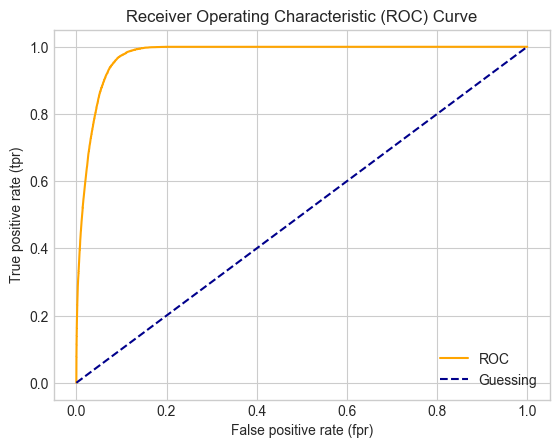


Results on TEST data:


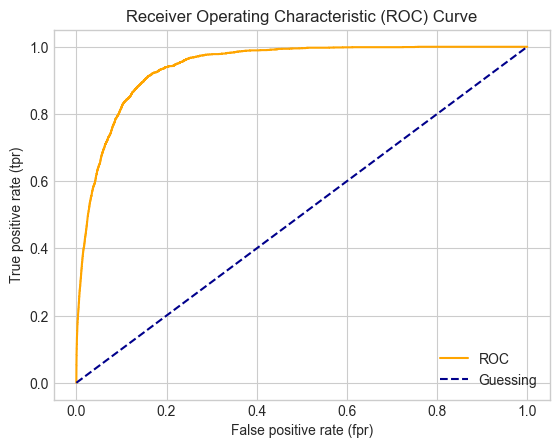

In [148]:
# ROC Curve
print("\nResults on TRAINING data:")
y_train_probs_positive = baseline_xbg.predict_proba(X_train)[:,1]
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_probs_positive)
Utility.plot_roc_curve(train_fpr, train_tpr)

print("\nResults on TEST data:")
y_test_probs_positive = baseline_xbg.predict_proba(X_test)[:,1]
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_probs_positive)
Utility.plot_roc_curve(test_fpr, test_tpr)

Classification Scores

In [149]:
# Scores
print("\nResults on TRAINING data:")
baseline_train_scores = Utility.evaluate_preds(y_train, y_train_pred)

print("\nResults on TEST data:")
baseline_test_scores = Utility.evaluate_preds(y_test, y_test_pred)


Results on TRAINING data:
Accuracy            :      89.60%
Precision           :       0.39
Recall              :       0.98
F1 score            :       0.56
F1 (macro) score    :       0.75
F1 (weighted) score :       0.92
ROC-AUC             :       0.94

Results on TEST data:
Accuracy            :      87.93%
Precision           :       0.35
Recall              :       0.85
F1 score            :       0.49
F1 (macro) score    :       0.71
F1 (weighted) score :       0.90
ROC-AUC             :       0.87


Finding: We can see that the model is overfit to the training data given the difference in the TRAINING vs. TEST F1 macro scores, and ROC-AUC values, respectively.  It is surprising how much better base XGBoost does than base and tuned (GridSearch) LogisticRegression and RandomForest models.

However, the TEST scores for F1 macro are better than the simple logit models built in the 'erwait_model_logit.ipynb' notebook and RFC models built in the 'erwait_randomforestclassifier.ipynb' notebooks. A concern is the relative low Precision score even with a reasonable F1 (macro) score, which indicates the proportion of "False Positives" is relatively higher with this model's predictions.

Feature Importances

citytype_urban            0.362128
id_gnch                   0.078791
id_mch                    0.058292
city_Edmonton             0.042856
id_uah                    0.042399
id_mhrh                   0.041874
id_plc                    0.035576
id_crh                    0.033115
hour                      0.029171
id_fsch                   0.025128
id_rah                    0.023284
id_shc                    0.019959
id_rdrh                   0.019535
id_dgh                    0.018811
id_nchc                   0.017294
id_sch                    0.017118
id_rgh                    0.016742
id_fmc                    0.016241
weekofyear                0.013854
id_lch                    0.012657
id_schc                   0.012163
id_stollery               0.010722
id_whc                    0.008508
dayofweek_Saturday        0.007427
dayofweek_Sunday          0.007313
dayperiod_night           0.007169
dayofweek_Monday          0.006701
dayofweek_Tuesday         0.005639
dayofweek_Wednesday 

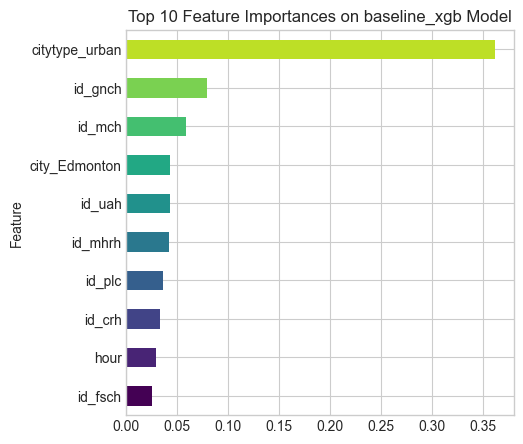

In [150]:
feat_importances = Utility.get_feature_importances_and_plot(baseline_xbg, X_train, 'baseline_xgb')
display(feat_importances)

## Build XGBClassifier model: "onehot"

Recall, this is the model where the data have these characteristics:
* all columns one-hot encoded, using Utility.RFC_ONEHOT_COLS_ALL
* 'dayperiod' which is collinear with 'hour', is kept in the data

In [151]:
df_model.head()

,dayofweek,weekofyear,hour,dayperiod,id,city,citytype,longwait
0,Friday,1,0,night,ach,Calgary,urban,0
1,Friday,1,0,night,crh,Lethbridge,rural,0
2,Friday,1,0,night,dgh,Devon,rural,0
3,Friday,1,0,night,fmc,Calgary,urban,1
4,Friday,1,0,night,fsch,Fort Saskatchewan,rural,0


In [152]:
# One-hot encoding of categorical columns as defined in Utility function (LOGIT_ONEHOT_COLS_A includes 'dayperiod')
df_model_onehot_cols_all = Utility.one_hot_encode_categorical_columns(df_model, Utility.RFC_ONEHOT_COLS_ALL)

# Turn booleans into 0's and 1'
Utility.convert_booleans(df_model_onehot_cols_all)

How does the dataframe look?

In [153]:
Utility.display_df_general_info(df_model_onehot_cols_all)

,longwait,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,weekofyear_2,weekofyear_3,weekofyear_4,weekofyear_5,weekofyear_6,weekofyear_7,weekofyear_8,weekofyear_9,weekofyear_10,weekofyear_11,weekofyear_12,weekofyear_13,weekofyear_14,weekofyear_15,weekofyear_16,weekofyear_17,weekofyear_18,weekofyear_19,weekofyear_20,weekofyear_21,weekofyear_22,weekofyear_23,weekofyear_24,weekofyear_25,weekofyear_26,weekofyear_27,weekofyear_31,weekofyear_32,weekofyear_33,weekofyear_34,weekofyear_35,weekofyear_36,weekofyear_37,weekofyear_38,weekofyear_39,weekofyear_40,weekofyear_41,weekofyear_42,weekofyear_43,weekofyear_44,weekofyear_45,weekofyear_46,weekofyear_47,weekofyear_48,weekofyear_49,weekofyear_50,weekofyear_51,weekofyear_52,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,dayperiod_evening,dayperiod_night,id_crh,id_dgh,id_fmc,id_fsch,id_gnch,id_lch,id_mch,id_mhrh,id_nchc,id_plc,id_rah,id_rdrh,id_rgh,id_sch,id_schc,id_shc,id_stollery,id_uah,id_whc,city_Devon,city_Edmonton,city_Fort Saskatchewan,city_Leduc,city_Lethbridge,city_Medicine Hat,city_Red Deer,city_Sherwood Park,city_St. Albert,city_Stony Plain,citytype_urban
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0



Shape of dataframe:
(181926, 110)

Columns of dataframe:
Index(['longwait', 'dayofweek_Monday', 'dayofweek_Saturday',
       'dayofweek_Sunday', 'dayofweek_Thursday', 'dayofweek_Tuesday',
       'dayofweek_Wednesday', 'weekofyear_2', 'weekofyear_3', 'weekofyear_4',
       ...
       'city_Edmonton', 'city_Fort Saskatchewan', 'city_Leduc',
       'city_Lethbridge', 'city_Medicine Hat', 'city_Red Deer',
       'city_Sherwood Park', 'city_St. Albert', 'city_Stony Plain',
       'citytype_urban'],
      dtype='object', length=110)

dtypes of dataframe:
longwait                  int64
dayofweek_Monday          int32
dayofweek_Saturday        int32
dayofweek_Sunday          int32
dayofweek_Thursday        int32
dayofweek_Tuesday         int32
dayofweek_Wednesday       int32
weekofyear_2              int32
weekofyear_3              int32
weekofyear_4              int32
weekofyear_5              int32
weekofyear_6              int32
weekofyear_7              int32
weekofyear_8              in

## Set X and y dataframes for "onehot" and "onehot_dropdayperiod" models

In [154]:
X_model = (df_model_onehot_cols_all.drop(['longwait'], axis=1))
y_model = (df_model_onehot_cols_all['longwait'])

## Train-Test Split for Model: "onehot"

In [155]:
# Make 80% training, 20% testing and shuffle the data
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=Utility.RANDOM_STATE_CONST, shuffle=True)

In [156]:
# Check what are the types and numbers in each of the 6 items I just created:
print(f"type(X_model): {type(X_model)}")
print(f"type(y_model): {type(y_model)}")

print(f"type(X_train): {type(X_train)}")
print(f"type(y_train): {type(y_train)}")

print(f"type(X_test): {type(X_test)}")
print(f"type(y_test): {type(y_test)}")

print(f"X_model.shape[0]: {X_model.shape[0]}")
print(f"y_model.shape[0]: {y_model.shape[0]}")

print(f"X_train.shape[0]: {X_train.shape[0]}")
print(f"y_train.shape[0]: {y_train.shape[0]}")

print(f"X_test.shape[0]: {X_test.shape[0]}")
print(f"y_test.shape[0]: {y_test.shape[0]}")

type(X_model): <class 'pandas.core.frame.DataFrame'>
type(y_model): <class 'pandas.core.series.Series'>
type(X_train): <class 'pandas.core.frame.DataFrame'>
type(y_train): <class 'pandas.core.series.Series'>
type(X_test): <class 'pandas.core.frame.DataFrame'>
type(y_test): <class 'pandas.core.series.Series'>
X_model.shape[0]: 181926
y_model.shape[0]: 181926
X_train.shape[0]: 145540
y_train.shape[0]: 145540
X_test.shape[0]: 36386
y_test.shape[0]: 36386


Check class distributions in y_train and y_test after the train_test_split.

This class imbalance is OK as we will set `scale_pos_weight` parameter on the XGBClassifier appropriately.

In [157]:
Utility.display_class_balance(y_train, y_test)

y_train_counter: Counter({0: 135805, 1: 9735}), 0: 93.31111721863405, 1: 6.6888827813659475
y_test_counter: Counter({0: 33863, 1: 2523}), 0: 93.06601440114329, 1: 6.933985598856703


In [158]:
onehot_xgb = XGBClassifier(objective='binary:logistic', tree_method='hist', random_state=Utility.RANDOM_STATE_CONST, scale_pos_weight=scale_pos_weight)
onehot_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [159]:
# Get predictions for X_train and X_test
y_train_pred = onehot_xgb.predict(X_train)
y_test_pred = onehot_xgb.predict(X_test)

## Evaluate model performance: "onehot"

Confusion Matrix

In [160]:
# Confusion Matrix
print("\nResults on TRAINING data:")
onehot_train_cm = Utility.print_confusion_matrix_with_labels(y_train, y_train_pred)

print("\nResults on TEST data:")
onehot_test_cm = Utility.print_confusion_matrix_with_labels(y_test, y_test_pred)


Results on TRAINING data:


,Predicted Positive,Predicted Negative
Actual Positive,9119,616
Actual Negative,21214,114591



Results on TEST data:


,Predicted Positive,Predicted Negative
Actual Positive,2215,308
Actual Negative,5410,28453


ROC Curve


Results on TRAINING data:


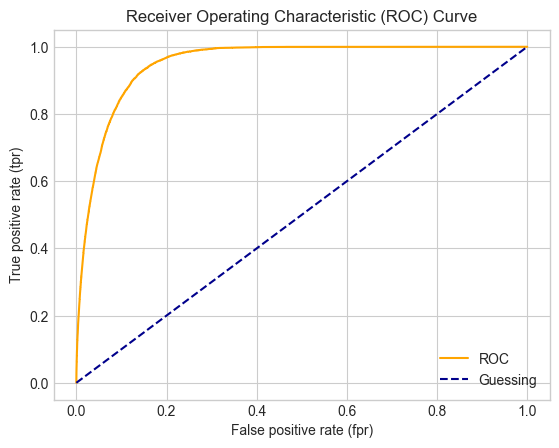


Results on TEST data:


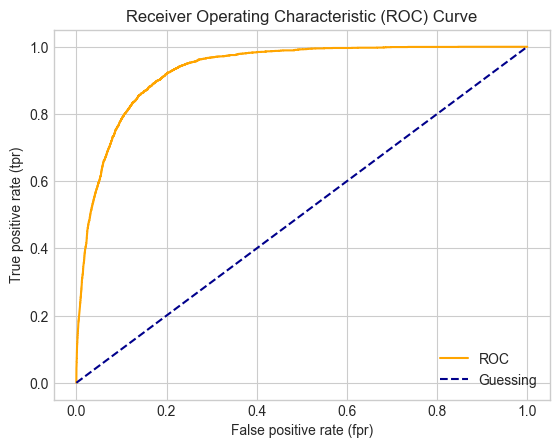

In [161]:
# ROC Curve
print("\nResults on TRAINING data:")
y_train_probs_positive = onehot_xgb.predict_proba(X_train)[:,1]
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_probs_positive)
Utility.plot_roc_curve(train_fpr, train_tpr)

print("\nResults on TEST data:")
y_test_probs_positive = onehot_xgb.predict_proba(X_test)[:,1]
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_probs_positive)
Utility.plot_roc_curve(test_fpr, test_tpr)

Classification Scores

In [162]:
# Scores
print("\nResults on TRAINING data:")
onehot_train_scores = Utility.evaluate_preds(y_train, y_train_pred)

print("\nResults on TEST data:")
onehot_test_scores = Utility.evaluate_preds(y_test, y_test_pred)


Results on TRAINING data:


Accuracy            :      85.00%
Precision           :       0.30
Recall              :       0.94
F1 score            :       0.46
F1 (macro) score    :       0.68
F1 (weighted) score :       0.88
ROC-AUC             :       0.89

Results on TEST data:
Accuracy            :      84.29%
Precision           :       0.29
Recall              :       0.88
F1 score            :       0.44
F1 (macro) score    :       0.67
F1 (weighted) score :       0.88
ROC-AUC             :       0.86


Finding: We can see that the model is overfit to the training data given the difference in the TRAINING vs. TEST F1 macro scores, and ROC-AUC values, respectively.  It is surprising how much better base XGBoost does than base and tuned (GridSearch) LogisticRegression and RandomForest models.

Surprisingly, when the entire dataset is one-hot encoded, the model performs more poorly than when the model is fed all categorical values for features, with the `enable_categorical=True` flag set.

Feature Importances

citytype_urban            0.080896
dayperiod_evening         0.043913
dayperiod_night           0.029661
id_gnch                   0.029418
id_mhrh                   0.023835
weekofyear_51             0.022340
hour_7                    0.021973
weekofyear_8              0.021586
hour_11                   0.021292
city_Edmonton             0.019526
id_crh                    0.018899
hour_17                   0.016683
hour_6                    0.016307
hour_10                   0.015639
hour_16                   0.015004
id_mch                    0.014624
id_rgh                    0.014586
hour_23                   0.014417
id_uah                    0.013559
id_sch                    0.013403
weekofyear_5              0.013104
id_lch                    0.013069
id_fmc                    0.013064
id_dgh                    0.012922
id_stollery               0.012892
id_fsch                   0.012765
id_nchc                   0.012418
hour_14                   0.011134
hour_9              

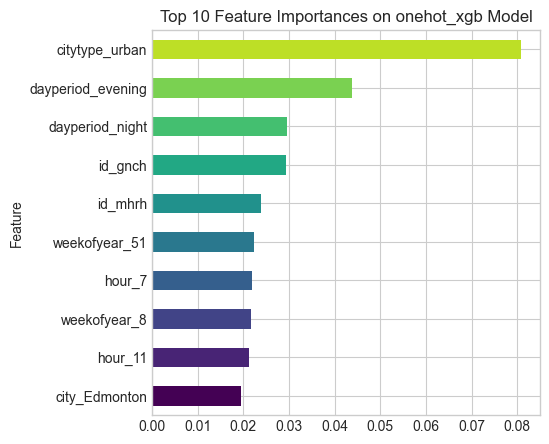

In [163]:
feat_importances = Utility.get_feature_importances_and_plot(onehot_xgb, X_train, 'onehot_xgb')
display(feat_importances)

## Build XGBClassifier model: "onehot_dropdayperiod"

Recall, this is the model where the data have these characteristics:
* same as "onehot", where all columns one-hot encoded, using Utility.RFC_ONEHOT_COLS_ALL
* 'dayperiod' which is collinear with 'hour', is dropped from the data

All we need to do is take the last model's X_train and X_test and drop these columns:
* `dayperiod_evening`
* `dayperiod_night`

In [164]:
# Recall what X_model and y_model currently are (from last 'onehot' model setup)
print("X_model.head() from last 'onehot' model setup:")
display(X_model.head())

print("y_model.head() from last 'onehot' model setup:")
display(y_model.head())

X_model.head() from last 'onehot' model setup:


,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,weekofyear_2,weekofyear_3,weekofyear_4,weekofyear_5,weekofyear_6,weekofyear_7,weekofyear_8,weekofyear_9,weekofyear_10,weekofyear_11,weekofyear_12,weekofyear_13,weekofyear_14,weekofyear_15,weekofyear_16,weekofyear_17,weekofyear_18,weekofyear_19,weekofyear_20,weekofyear_21,weekofyear_22,weekofyear_23,weekofyear_24,weekofyear_25,weekofyear_26,weekofyear_27,weekofyear_31,weekofyear_32,weekofyear_33,weekofyear_34,weekofyear_35,weekofyear_36,weekofyear_37,weekofyear_38,weekofyear_39,weekofyear_40,weekofyear_41,weekofyear_42,weekofyear_43,weekofyear_44,weekofyear_45,weekofyear_46,weekofyear_47,weekofyear_48,weekofyear_49,weekofyear_50,weekofyear_51,weekofyear_52,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,dayperiod_evening,dayperiod_night,id_crh,id_dgh,id_fmc,id_fsch,id_gnch,id_lch,id_mch,id_mhrh,id_nchc,id_plc,id_rah,id_rdrh,id_rgh,id_sch,id_schc,id_shc,id_stollery,id_uah,id_whc,city_Devon,city_Edmonton,city_Fort Saskatchewan,city_Leduc,city_Lethbridge,city_Medicine Hat,city_Red Deer,city_Sherwood Park,city_St. Albert,city_Stony Plain,citytype_urban
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


y_model.head() from last 'onehot' model setup:


0    0
1    0
2    0
3    1
4    0
Name: longwait, dtype: int64

Remove `dayperiod_evening` and `dayperiod_night` from `X_train` and `X_test`

In [165]:
X_train.drop(['dayperiod_evening', 'dayperiod_night'], axis=1, inplace=True)
X_test.drop(['dayperiod_evening', 'dayperiod_night'], axis=1, inplace=True)

In [166]:
# What do they look like now?
Utility.display_df_general_info(X_train)
Utility.display_df_general_info(X_test)

,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,weekofyear_2,weekofyear_3,weekofyear_4,weekofyear_5,weekofyear_6,weekofyear_7,weekofyear_8,weekofyear_9,weekofyear_10,weekofyear_11,weekofyear_12,weekofyear_13,weekofyear_14,weekofyear_15,weekofyear_16,weekofyear_17,weekofyear_18,weekofyear_19,weekofyear_20,weekofyear_21,weekofyear_22,weekofyear_23,weekofyear_24,weekofyear_25,weekofyear_26,weekofyear_27,weekofyear_31,weekofyear_32,weekofyear_33,weekofyear_34,weekofyear_35,weekofyear_36,weekofyear_37,weekofyear_38,weekofyear_39,weekofyear_40,weekofyear_41,weekofyear_42,weekofyear_43,weekofyear_44,weekofyear_45,weekofyear_46,weekofyear_47,weekofyear_48,weekofyear_49,weekofyear_50,weekofyear_51,weekofyear_52,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,id_crh,id_dgh,id_fmc,id_fsch,id_gnch,id_lch,id_mch,id_mhrh,id_nchc,id_plc,id_rah,id_rdrh,id_rgh,id_sch,id_schc,id_shc,id_stollery,id_uah,id_whc,city_Devon,city_Edmonton,city_Fort Saskatchewan,city_Leduc,city_Lethbridge,city_Medicine Hat,city_Red Deer,city_Sherwood Park,city_St. Albert,city_Stony Plain,citytype_urban
94896,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
156867,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
152692,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
22182,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
172071,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1



Shape of dataframe:
(145540, 107)

Columns of dataframe:
Index(['dayofweek_Monday', 'dayofweek_Saturday', 'dayofweek_Sunday',
       'dayofweek_Thursday', 'dayofweek_Tuesday', 'dayofweek_Wednesday',
       'weekofyear_2', 'weekofyear_3', 'weekofyear_4', 'weekofyear_5',
       ...
       'city_Edmonton', 'city_Fort Saskatchewan', 'city_Leduc',
       'city_Lethbridge', 'city_Medicine Hat', 'city_Red Deer',
       'city_Sherwood Park', 'city_St. Albert', 'city_Stony Plain',
       'citytype_urban'],
      dtype='object', length=107)

dtypes of dataframe:
dayofweek_Monday          int32
dayofweek_Saturday        int32
dayofweek_Sunday          int32
dayofweek_Thursday        int32
dayofweek_Tuesday         int32
dayofweek_Wednesday       int32
weekofyear_2              int32
weekofyear_3              int32
weekofyear_4              int32
weekofyear_5              int32
weekofyear_6              int32
weekofyear_7              int32
weekofyear_8              int32
weekofyear_9            

,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,weekofyear_2,weekofyear_3,weekofyear_4,weekofyear_5,weekofyear_6,weekofyear_7,weekofyear_8,weekofyear_9,weekofyear_10,weekofyear_11,weekofyear_12,weekofyear_13,weekofyear_14,weekofyear_15,weekofyear_16,weekofyear_17,weekofyear_18,weekofyear_19,weekofyear_20,weekofyear_21,weekofyear_22,weekofyear_23,weekofyear_24,weekofyear_25,weekofyear_26,weekofyear_27,weekofyear_31,weekofyear_32,weekofyear_33,weekofyear_34,weekofyear_35,weekofyear_36,weekofyear_37,weekofyear_38,weekofyear_39,weekofyear_40,weekofyear_41,weekofyear_42,weekofyear_43,weekofyear_44,weekofyear_45,weekofyear_46,weekofyear_47,weekofyear_48,weekofyear_49,weekofyear_50,weekofyear_51,weekofyear_52,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,id_crh,id_dgh,id_fmc,id_fsch,id_gnch,id_lch,id_mch,id_mhrh,id_nchc,id_plc,id_rah,id_rdrh,id_rgh,id_sch,id_schc,id_shc,id_stollery,id_uah,id_whc,city_Devon,city_Edmonton,city_Fort Saskatchewan,city_Leduc,city_Lethbridge,city_Medicine Hat,city_Red Deer,city_Sherwood Park,city_St. Albert,city_Stony Plain,citytype_urban
109432,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
59969,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
61225,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
117768,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
75800,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1



Shape of dataframe:
(36386, 107)

Columns of dataframe:
Index(['dayofweek_Monday', 'dayofweek_Saturday', 'dayofweek_Sunday',
       'dayofweek_Thursday', 'dayofweek_Tuesday', 'dayofweek_Wednesday',
       'weekofyear_2', 'weekofyear_3', 'weekofyear_4', 'weekofyear_5',
       ...
       'city_Edmonton', 'city_Fort Saskatchewan', 'city_Leduc',
       'city_Lethbridge', 'city_Medicine Hat', 'city_Red Deer',
       'city_Sherwood Park', 'city_St. Albert', 'city_Stony Plain',
       'citytype_urban'],
      dtype='object', length=107)

dtypes of dataframe:
dayofweek_Monday          int32
dayofweek_Saturday        int32
dayofweek_Sunday          int32
dayofweek_Thursday        int32
dayofweek_Tuesday         int32
dayofweek_Wednesday       int32
weekofyear_2              int32
weekofyear_3              int32
weekofyear_4              int32
weekofyear_5              int32
weekofyear_6              int32
weekofyear_7              int32
weekofyear_8              int32
weekofyear_9             

In [167]:
# Check what are the types and numbers in each of the 6 items I just created:
print(f"type(X_train): {type(X_train)}")
print(f"type(y_train): {type(y_train)}")

print(f"type(X_test): {type(X_test)}")
print(f"type(y_test): {type(y_test)}")

print(f"X_train.shape[0]: {X_train.shape[0]}")
print(f"y_train.shape[0]: {y_train.shape[0]}")

print(f"X_test.shape[0]: {X_test.shape[0]}")
print(f"y_test.shape[0]: {y_test.shape[0]}")

type(X_train): <class 'pandas.core.frame.DataFrame'>
type(y_train): <class 'pandas.core.series.Series'>
type(X_test): <class 'pandas.core.frame.DataFrame'>
type(y_test): <class 'pandas.core.series.Series'>
X_train.shape[0]: 145540
y_train.shape[0]: 145540
X_test.shape[0]: 36386
y_test.shape[0]: 36386


Check class distributions in y_train and y_test after the train_test_split.

This class imbalance is OK as we will set `scale_pos_weight` parameter on the XGBClassifier appropriately.

In [168]:
Utility.display_class_balance(y_train, y_test)

y_train_counter: Counter({0: 135805, 1: 9735}), 0: 93.31111721863405, 1: 6.6888827813659475
y_test_counter: Counter({0: 33863, 1: 2523}), 0: 93.06601440114329, 1: 6.933985598856703


In [169]:
onehot_dropdayperiod_xgb = XGBClassifier(objective='binary:logistic', tree_method='hist', random_state=Utility.RANDOM_STATE_CONST, scale_pos_weight=scale_pos_weight)
onehot_dropdayperiod_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [170]:
# Get predictions for X_train and X_test
y_train_pred = onehot_dropdayperiod_xgb.predict(X_train)
y_test_pred = onehot_dropdayperiod_xgb.predict(X_test)

## Evaluate model performance: "onehot_dropdayperiod"

Confusion Matrix

In [171]:
# Confusion Matrix
print("\nResults on TRAINING data:")
onehot_dropdayperiod_train_cm = Utility.print_confusion_matrix_with_labels(y_train, y_train_pred)

print("\nResults on TEST data:")
onehot_dropdayperiod_test_cm = Utility.print_confusion_matrix_with_labels(y_test, y_test_pred)


Results on TRAINING data:


,Predicted Positive,Predicted Negative
Actual Positive,9065,670
Actual Negative,22886,112919



Results on TEST data:


,Predicted Positive,Predicted Negative
Actual Positive,2219,304
Actual Negative,5867,27996


ROC Curve


Results on TRAINING data:


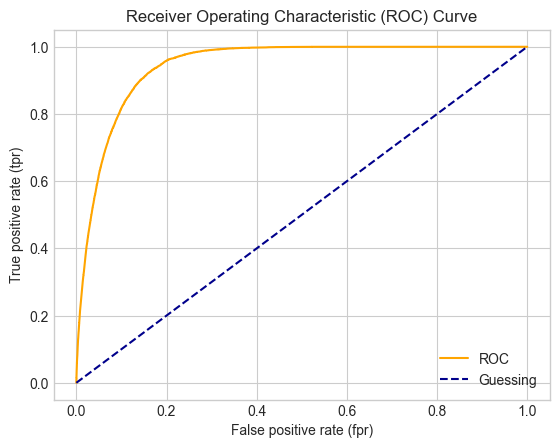


Results on TEST data:


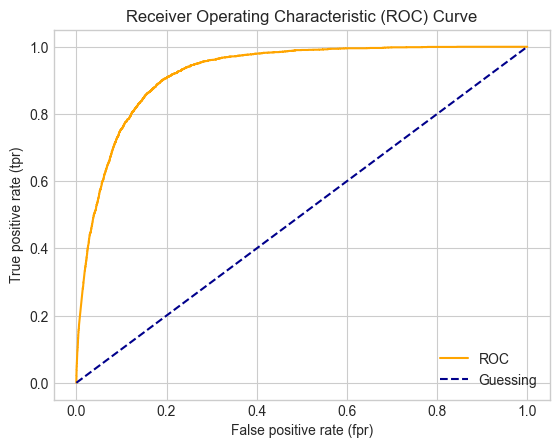

In [172]:
# ROC Curve
print("\nResults on TRAINING data:")
y_train_probs_positive = onehot_dropdayperiod_xgb.predict_proba(X_train)[:,1]
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_probs_positive)
Utility.plot_roc_curve(train_fpr, train_tpr)

print("\nResults on TEST data:")
y_test_probs_positive = onehot_dropdayperiod_xgb.predict_proba(X_test)[:,1]
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_probs_positive)
Utility.plot_roc_curve(test_fpr, test_tpr)

Classification Scores

In [173]:
# Scores
print("\nResults on TRAINING data:")
onehot_dropdayperiod_train_scores = Utility.evaluate_preds(y_train, y_train_pred)

print("\nResults on TEST data:")
onehot_dropdayperiod_test_scores = Utility.evaluate_preds(y_test, y_test_pred)


Results on TRAINING data:


Accuracy            :      83.81%
Precision           :       0.28
Recall              :       0.93
F1 score            :       0.43
F1 (macro) score    :       0.67
F1 (weighted) score :       0.87
ROC-AUC             :       0.88

Results on TEST data:
Accuracy            :      83.04%
Precision           :       0.27
Recall              :       0.88
F1 score            :       0.42
F1 (macro) score    :       0.66
F1 (weighted) score :       0.87
ROC-AUC             :       0.85


Finding: We can see that the model is overfit to the training data given the difference in the TRAINING vs. TEST F1 macro scores, and ROC-AUC values, respectively.  It is surprising how much better base XGBoost does than base and tuned (GridSearch) LogisticRegression and RandomForest models.

Dropping `dayperiod`, with all other things the same, does not make this model perform better, overall, than the model previous.  This may indicate, like seen in Logit and RFC, that the `dayperiod` is a more important feature than the `hour` feature from which it was derived.  This is something that we could explore by examining feature importances.

Feature Importances

hour_11                   0.067629
hour_10                   0.061627
citytype_urban            0.059574
hour_12                   0.042994
id_gnch                   0.042045
hour_9                    0.039585
hour_13                   0.039416
hour_14                   0.034311
hour_8                    0.027581
hour_15                   0.021067
weekofyear_51             0.019130
id_mhrh                   0.017780
hour_16                   0.017757
hour_2                    0.017113
id_crh                    0.014335
hour_1                    0.013875
weekofyear_8              0.013840
hour_7                    0.013761
hour_3                    0.013624
hour_17                   0.012949
weekofyear_5              0.012090
id_sch                    0.011593
id_fsch                   0.011246
hour_23                   0.011036
id_uah                    0.009993
id_lch                    0.009927
id_plc                    0.009792
weekofyear_4              0.009612
hour_4              

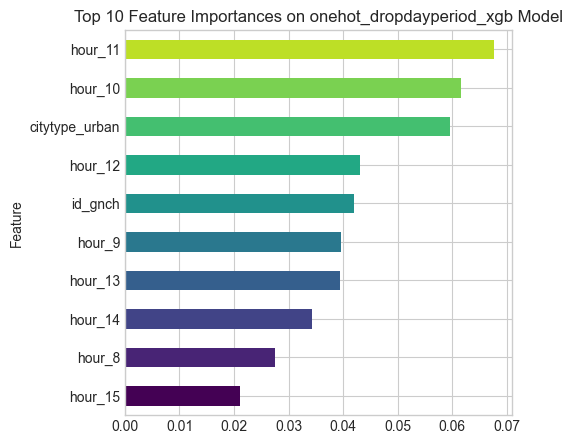

In [174]:
feat_importances = Utility.get_feature_importances_and_plot(onehot_dropdayperiod_xgb, X_train, 'onehot_dropdayperiod_xgb')
display(feat_importances)

## Build XGBClassifier model: "labelencoded"

In [175]:
# Make a copy of df_model first
df_model_label = df_model.copy()

# Drop 'dayperiod' column
df_model_label.drop(['dayperiod'], axis=1, inplace=True)

# Label Encode all remaining columns except 'longwait'
label_encoder = LabelEncoder()
for column in df_model_label.columns[df_model_label.columns != 'longwait']:
    df_model_label[column] = label_encoder.fit_transform(df_model_label[column])

What does the label-encoded dataframe look like now?

In [176]:
Utility.display_df_general_info(df_model_label)

,dayofweek,weekofyear,hour,id,city,citytype,longwait
0,0,0,0,0,0,1,0
1,0,0,0,1,5,0,0
2,0,0,0,2,1,0,0
3,0,0,0,3,0,1,1
4,0,0,0,4,3,0,0



Shape of dataframe:
(181926, 7)

Columns of dataframe:
Index(['dayofweek', 'weekofyear', 'hour', 'id', 'city', 'citytype',
       'longwait'],
      dtype='object')

dtypes of dataframe:
dayofweek     int32
weekofyear    int64
hour          int64
id            int32
city          int32
citytype      int32
longwait      int64
dtype: object


## Set X and y dataframes for "labelencoded" model

In [177]:
X_model = (df_model_label.drop(['longwait'], axis=1))
y_model = (df_model_label['longwait'])

## Train-Test Split for Model: "labelencoded"

In [178]:
# Make 80% training, 20% testing and shuffle the data
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=Utility.RANDOM_STATE_CONST, shuffle=True)

In [179]:
# Check what are the types and numbers in each of the 6 items I just created:
print(f"type(X_model): {type(X_model)}")
print(f"type(y_model): {type(y_model)}")

print(f"type(X_train): {type(X_train)}")
print(f"type(y_train): {type(y_train)}")

print(f"type(X_test): {type(X_test)}")
print(f"type(y_test): {type(y_test)}")

print(f"X_model.shape[0]: {X_model.shape[0]}")
print(f"y_model.shape[0]: {y_model.shape[0]}")

print(f"X_train.shape[0]: {X_train.shape[0]}")
print(f"y_train.shape[0]: {y_train.shape[0]}")

print(f"X_test.shape[0]: {X_test.shape[0]}")
print(f"y_test.shape[0]: {y_test.shape[0]}")

type(X_model): <class 'pandas.core.frame.DataFrame'>
type(y_model): <class 'pandas.core.series.Series'>
type(X_train): <class 'pandas.core.frame.DataFrame'>
type(y_train): <class 'pandas.core.series.Series'>
type(X_test): <class 'pandas.core.frame.DataFrame'>
type(y_test): <class 'pandas.core.series.Series'>
X_model.shape[0]: 181926
y_model.shape[0]: 181926
X_train.shape[0]: 145540
y_train.shape[0]: 145540
X_test.shape[0]: 36386
y_test.shape[0]: 36386


Check class distributions in y_train and y_test after the train_test_split.

This class imbalance is OK as we will set `scale_pos_weight` parameter on the XGBClassifier appropriately.

In [180]:
Utility.display_class_balance(y_train, y_test)

y_train_counter: Counter({0: 135805, 1: 9735}), 0: 93.31111721863405, 1: 6.6888827813659475
y_test_counter: Counter({0: 33863, 1: 2523}), 0: 93.06601440114329, 1: 6.933985598856703


In [181]:
labelencoded_xgb = XGBClassifier(objective='binary:logistic', tree_method='hist', random_state=Utility.RANDOM_STATE_CONST, scale_pos_weight=scale_pos_weight)
labelencoded_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [182]:
# Get predictions for X_train and X_test
y_train_pred = labelencoded_xgb.predict(X_train)
y_test_pred = labelencoded_xgb.predict(X_test)

## Evaluate model performance: "labelencoded"

Confusion Matrix

In [183]:
# Confusion Matrix
print("\nResults on TRAINING data:")
labelencoded_train_cm = Utility.print_confusion_matrix_with_labels(y_train, y_train_pred)

print("\nResults on TEST data:")
labelencoded_test_cm = Utility.print_confusion_matrix_with_labels(y_test, y_test_pred)


Results on TRAINING data:


,Predicted Positive,Predicted Negative
Actual Positive,9246,489
Actual Negative,18199,117606



Results on TEST data:


,Predicted Positive,Predicted Negative
Actual Positive,2242,281
Actual Negative,4683,29180


ROC Curve


Results on TRAINING data:


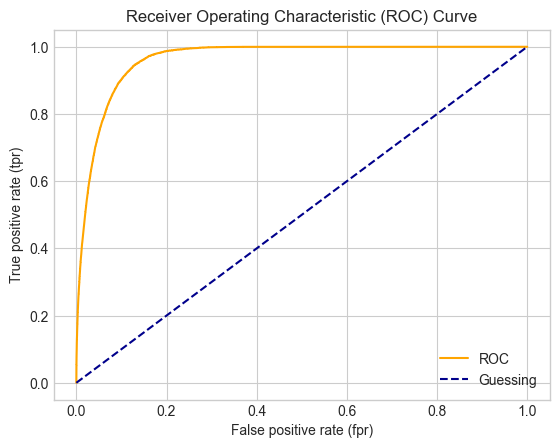


Results on TEST data:


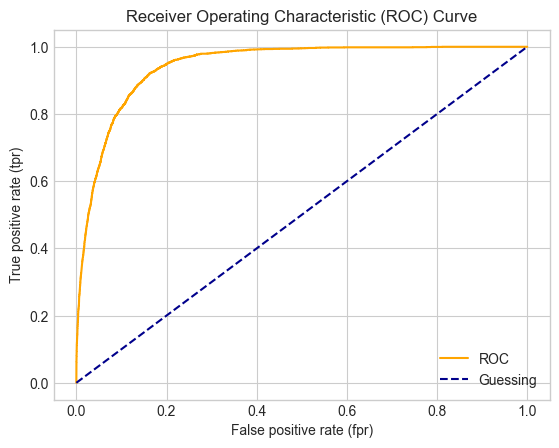

In [184]:
# ROC Curve
print("\nResults on TRAINING data:")
y_train_probs_positive = labelencoded_xgb.predict_proba(X_train)[:,1]
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_probs_positive)
Utility.plot_roc_curve(train_fpr, train_tpr)

print("\nResults on TEST data:")
y_test_probs_positive = labelencoded_xgb.predict_proba(X_test)[:,1]
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_probs_positive)
Utility.plot_roc_curve(test_fpr, test_tpr)

Classification Scores

In [185]:
# Scores
print("\nResults on TRAINING data:")
labelencoded_train_scores = Utility.evaluate_preds(y_train, y_train_pred)

print("\nResults on TEST data:")
labelencoded_test_scores = Utility.evaluate_preds(y_test, y_test_pred)


Results on TRAINING data:


Accuracy            :      87.16%
Precision           :       0.34
Recall              :       0.95
F1 score            :       0.50
F1 (macro) score    :       0.71
F1 (weighted) score :       0.90
ROC-AUC             :       0.91

Results on TEST data:
Accuracy            :      86.36%
Precision           :       0.32
Recall              :       0.89
F1 score            :       0.47
F1 (macro) score    :       0.70
F1 (weighted) score :       0.89
ROC-AUC             :       0.88


Finding: We can see that the model is overfit to the training data given the difference in the TRAINING vs. TEST F1 macro scores, and ROC-AUC values, respectively.  It is surprising how much better base XGBoost does than base and tuned (GridSearch) LogisticRegression and RandomForest models.

The fully Label Encoded dataset so far has created the best overall performance scores of all the experiments.  Let's see if it keeps being the best in the next 2 experiments with slightly different feature preparations.

Feature Importances

citytype      0.703117
hour          0.118079
id            0.065237
city          0.053270
weekofyear    0.035701
dayofweek     0.024595
dtype: float32

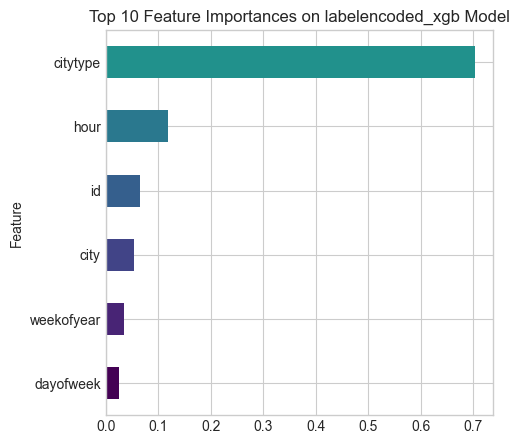

In [186]:
feat_importances = Utility.get_feature_importances_and_plot(labelencoded_xgb, X_train, 'labelencoded_xgb')
display(feat_importances)

## Build XGBClassifier model: "labelpartial"

In [187]:
# Make a copy of df_model first
df_model_labelpartial = df_model.copy()

# One-hot encoding of categorical columns as defined in Utility function (LOGIT_ONEHOT_COLS_A includes 'dayperiod')
df_model_labelpartial = Utility.one_hot_encode_categorical_columns(df_model_labelpartial, Utility.LOGIT_ONEHOT_COLS_A)

# Turn booleans into 0's and 1'
Utility.convert_booleans(df_model_labelpartial)

# Label Encode 'hour' and 'weekofyear'
label_encoder = LabelEncoder()
for column in ['hour', 'weekofyear']:
    df_model_labelpartial[column] = label_encoder.fit_transform(df_model_labelpartial[column])

What does the label-encoded dataframe look like now?

In [188]:
Utility.display_df_general_info(df_model_labelpartial)

,weekofyear,hour,longwait,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,dayperiod_evening,dayperiod_night,id_crh,id_dgh,id_fmc,id_fsch,id_gnch,id_lch,id_mch,id_mhrh,id_nchc,id_plc,id_rah,id_rdrh,id_rgh,id_sch,id_schc,id_shc,id_stollery,id_uah,id_whc,city_Devon,city_Edmonton,city_Fort Saskatchewan,city_Leduc,city_Lethbridge,city_Medicine Hat,city_Red Deer,city_Sherwood Park,city_St. Albert,city_Stony Plain,citytype_urban
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0



Shape of dataframe:
(181926, 41)

Columns of dataframe:
Index(['weekofyear', 'hour', 'longwait', 'dayofweek_Monday',
       'dayofweek_Saturday', 'dayofweek_Sunday', 'dayofweek_Thursday',
       'dayofweek_Tuesday', 'dayofweek_Wednesday', 'dayperiod_evening',
       'dayperiod_night', 'id_crh', 'id_dgh', 'id_fmc', 'id_fsch', 'id_gnch',
       'id_lch', 'id_mch', 'id_mhrh', 'id_nchc', 'id_plc', 'id_rah', 'id_rdrh',
       'id_rgh', 'id_sch', 'id_schc', 'id_shc', 'id_stollery', 'id_uah',
       'id_whc', 'city_Devon', 'city_Edmonton', 'city_Fort Saskatchewan',
       'city_Leduc', 'city_Lethbridge', 'city_Medicine Hat', 'city_Red Deer',
       'city_Sherwood Park', 'city_St. Albert', 'city_Stony Plain',
       'citytype_urban'],
      dtype='object')

dtypes of dataframe:
weekofyear                int64
hour                      int64
longwait                  int64
dayofweek_Monday          int32
dayofweek_Saturday        int32
dayofweek_Sunday          int32
dayofweek_Thursday        

In [189]:
# Confirm that 'hour' and 'weekofyear' have indeed been label-encoded
display(df_model_labelpartial['hour'].value_counts())
display(df_model_labelpartial['weekofyear'].value_counts())

# Confirm 'dayperiod' is one-hot-encoded
display(df_model_labelpartial['dayperiod_evening'].value_counts())

hour
20    7733
18    7668
13    7660
17    7636
12    7627
9     7626
16    7619
14    7610
22    7606
23    7603
15    7595
11    7588
21    7587
19    7576
10    7571
0     7570
8     7552
5     7536
1     7530
7     7530
6     7521
4     7471
2     7461
3     7450
Name: count, dtype: int64

weekofyear
41    6712
42    6700
35    6691
37    6660
36    6644
40    5722
38    4640
43    4609
34    4100
32    3360
28    3360
46    3360
20    3360
18    3360
29    3360
30    3360
13    3360
11    3360
6     3360
5     3360
48    3360
10    3358
19    3358
16    3354
47    3354
4     3354
8     3352
45    3350
31    3347
0     3340
1     3340
15    3340
7     3340
39    3340
12    3339
2     3338
9     3336
33    3325
14    3318
24    3317
25    3314
44    3310
23    3217
22    3197
21    3161
17    3125
3     2904
27    2060
26    1340
Name: count, dtype: int64

dayperiod_evening
0    120898
1     61028
Name: count, dtype: int64

## Set X and y dataframes for "labelpartial" model

In [190]:
X_model = (df_model_labelpartial.drop(['longwait'], axis=1))
y_model = (df_model_labelpartial['longwait'])

## Train-Test Split for Model: "labelpartial"

In [191]:
# Make 80% training, 20% testing and shuffle the data
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=Utility.RANDOM_STATE_CONST, shuffle=True)

In [192]:
# Check what are the types and numbers in each of the 6 items I just created:
print(f"type(X_model): {type(X_model)}")
print(f"type(y_model): {type(y_model)}")

print(f"type(X_train): {type(X_train)}")
print(f"type(y_train): {type(y_train)}")

print(f"type(X_test): {type(X_test)}")
print(f"type(y_test): {type(y_test)}")

print(f"X_model.shape: {X_model.shape}")
print(f"y_model.shape: {y_model.shape}")

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")

print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

type(X_model): <class 'pandas.core.frame.DataFrame'>
type(y_model): <class 'pandas.core.series.Series'>
type(X_train): <class 'pandas.core.frame.DataFrame'>
type(y_train): <class 'pandas.core.series.Series'>
type(X_test): <class 'pandas.core.frame.DataFrame'>
type(y_test): <class 'pandas.core.series.Series'>
X_model.shape: (181926, 40)
y_model.shape: (181926,)
X_train.shape: (145540, 40)
y_train.shape: (145540,)
X_test.shape: (36386, 40)
y_test.shape: (36386,)


Check class distributions in y_train and y_test after the train_test_split.

This class imbalance is OK as we will set `scale_pos_weight` parameter on the XGBClassifier appropriately.

In [193]:
Utility.display_class_balance(y_train, y_test)

y_train_counter: Counter({0: 135805, 1: 9735}), 0: 93.31111721863405, 1: 6.6888827813659475
y_test_counter: Counter({0: 33863, 1: 2523}), 0: 93.06601440114329, 1: 6.933985598856703


In [194]:
labelpartial_xgb = XGBClassifier(objective='binary:logistic', tree_method='hist', random_state=Utility.RANDOM_STATE_CONST, scale_pos_weight=scale_pos_weight)
labelpartial_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [195]:
# Get predictions for X_train and X_test
y_train_pred = labelpartial_xgb.predict(X_train)
y_test_pred = labelpartial_xgb.predict(X_test)

## Evaluate model performance: "labelpartial"

Confusion Matrix

In [196]:
# Confusion Matrix
print("\nResults on TRAINING data:")
labelpartial_train_cm = Utility.print_confusion_matrix_with_labels(y_train, y_train_pred)

print("\nResults on TEST data:")
labelpartial_test_cm = Utility.print_confusion_matrix_with_labels(y_test, y_test_pred)


Results on TRAINING data:


,Predicted Positive,Predicted Negative
Actual Positive,9186,549
Actual Negative,18685,117120



Results on TEST data:


,Predicted Positive,Predicted Negative
Actual Positive,2263,260
Actual Negative,4783,29080


ROC Curve


Results on TRAINING data:


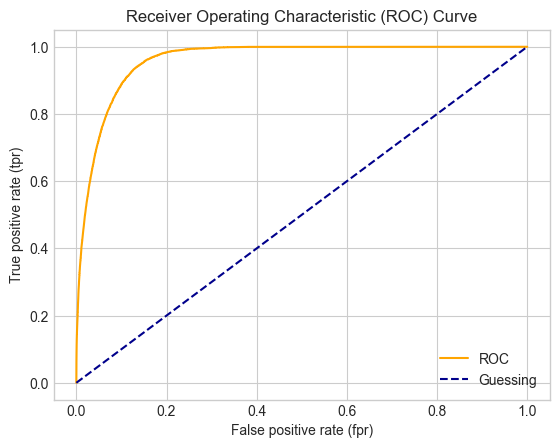


Results on TEST data:


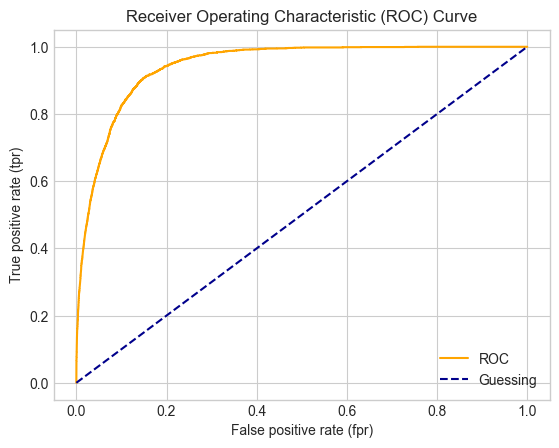

In [197]:
# ROC Curve
print("\nResults on TRAINING data:")
y_train_probs_positive = labelpartial_xgb.predict_proba(X_train)[:,1]
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_probs_positive)
Utility.plot_roc_curve(train_fpr, train_tpr)

print("\nResults on TEST data:")
y_test_probs_positive = labelpartial_xgb.predict_proba(X_test)[:,1]
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_probs_positive)
Utility.plot_roc_curve(test_fpr, test_tpr)

Classification Scores

In [198]:
# Scores
print("\nResults on TRAINING data:")
labelpartial_train_scores = Utility.evaluate_preds(y_train, y_train_pred)

print("\nResults on TEST data:")
labelpartial_test_scores = Utility.evaluate_preds(y_test, y_test_pred)


Results on TRAINING data:


Accuracy            :      86.78%
Precision           :       0.33
Recall              :       0.94
F1 score            :       0.49
F1 (macro) score    :       0.71
F1 (weighted) score :       0.89
ROC-AUC             :       0.90

Results on TEST data:
Accuracy            :      86.14%
Precision           :       0.32
Recall              :       0.90
F1 score            :       0.47
F1 (macro) score    :       0.70
F1 (weighted) score :       0.89
ROC-AUC             :       0.88


Finding: We can see that the model is overfit to the training data given the difference in the TRAINING vs. TEST F1 macro scores, and ROC-AUC values, respectively.  It is surprising how much better base XGBoost does than base and tuned (GridSearch) LogisticRegression and RandomForest models.

The leaving of the `dayofweek` and `hour` fields as label encoded while other features are one-hot encoded, does not seem to make much difference compared to making all features label encoded.

However, the TEST scores for F1 macro are better than the simple logit models built in the 'erwait_model_logit.ipynb' notebook.  The ROC-AUC score at 0.66 is not as good as the best simple logit models built, though.

Feature Importances

citytype_urban            0.437762
id_gnch                   0.059259
city_Edmonton             0.044815
id_mch                    0.042333
id_uah                    0.039710
id_mhrh                   0.031153
hour                      0.027670
id_crh                    0.026583
id_rgh                    0.025073
id_nchc                   0.023199
id_fsch                   0.021746
id_stollery               0.021738
id_fmc                    0.021516
id_sch                    0.018611
id_plc                    0.017696
id_schc                   0.015920
id_whc                    0.015052
id_shc                    0.014473
id_rah                    0.014184
id_rdrh                   0.012823
id_dgh                    0.011746
id_lch                    0.011215
weekofyear                0.008328
dayofweek_Sunday          0.008248
dayofweek_Saturday        0.008191
dayofweek_Monday          0.006220
dayofweek_Tuesday         0.005833
dayofweek_Wednesday       0.004558
dayofweek_Thursday  

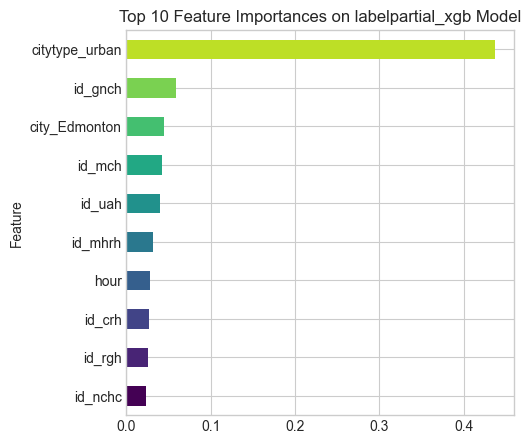

In [199]:
feat_importances = Utility.get_feature_importances_and_plot(labelpartial_xgb, X_train, 'labelpartial_xgb')
display(feat_importances)

## Build XGBClassifier model: "labelpartialsmote"

We will build a model using data set up same as "LabelPartial", but with SMOTE and RandomUnderSampler (sampling_strategy=0.1 and 0.5, respectively, as those were used on basic LogisticRegression) and `scale_pos_weight` set appropriately after the splits.

In [200]:
# Make a copy of df_model first
df_model_labelpartial = df_model.copy()

# One-hot encoding of categorical columns as defined in Utility function (LOGIT_ONEHOT_COLS_A includes 'dayperiod')
df_model_labelpartial = Utility.one_hot_encode_categorical_columns(df_model_labelpartial, Utility.LOGIT_ONEHOT_COLS_A)

# Turn booleans into 0's and 1'
Utility.convert_booleans(df_model_labelpartial)

# Label Encode 'hour' and 'weekofyear'
label_encoder = LabelEncoder()
for column in ['hour', 'weekofyear']:
    df_model_labelpartial[column] = label_encoder.fit_transform(df_model_labelpartial[column])

What does the label-encoded dataframe look like now?

In [201]:
Utility.display_df_general_info(df_model_labelpartial)

,weekofyear,hour,longwait,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,dayperiod_evening,dayperiod_night,id_crh,id_dgh,id_fmc,id_fsch,id_gnch,id_lch,id_mch,id_mhrh,id_nchc,id_plc,id_rah,id_rdrh,id_rgh,id_sch,id_schc,id_shc,id_stollery,id_uah,id_whc,city_Devon,city_Edmonton,city_Fort Saskatchewan,city_Leduc,city_Lethbridge,city_Medicine Hat,city_Red Deer,city_Sherwood Park,city_St. Albert,city_Stony Plain,citytype_urban
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0



Shape of dataframe:
(181926, 41)

Columns of dataframe:
Index(['weekofyear', 'hour', 'longwait', 'dayofweek_Monday',
       'dayofweek_Saturday', 'dayofweek_Sunday', 'dayofweek_Thursday',
       'dayofweek_Tuesday', 'dayofweek_Wednesday', 'dayperiod_evening',
       'dayperiod_night', 'id_crh', 'id_dgh', 'id_fmc', 'id_fsch', 'id_gnch',
       'id_lch', 'id_mch', 'id_mhrh', 'id_nchc', 'id_plc', 'id_rah', 'id_rdrh',
       'id_rgh', 'id_sch', 'id_schc', 'id_shc', 'id_stollery', 'id_uah',
       'id_whc', 'city_Devon', 'city_Edmonton', 'city_Fort Saskatchewan',
       'city_Leduc', 'city_Lethbridge', 'city_Medicine Hat', 'city_Red Deer',
       'city_Sherwood Park', 'city_St. Albert', 'city_Stony Plain',
       'citytype_urban'],
      dtype='object')

dtypes of dataframe:
weekofyear                int64
hour                      int64
longwait                  int64
dayofweek_Monday          int32
dayofweek_Saturday        int32
dayofweek_Sunday          int32
dayofweek_Thursday        

In [202]:
# Confirm that 'hour' and 'weekofyear' have indeed been label-encoded
display(df_model_labelpartial['hour'].value_counts())
display(df_model_labelpartial['weekofyear'].value_counts())

# Confirm 'dayperiod' is one-hot-encoded
display(df_model_labelpartial['dayperiod_evening'].value_counts())

hour
20    7733
18    7668
13    7660
17    7636
12    7627
9     7626
16    7619
14    7610
22    7606
23    7603
15    7595
11    7588
21    7587
19    7576
10    7571
0     7570
8     7552
5     7536
1     7530
7     7530
6     7521
4     7471
2     7461
3     7450
Name: count, dtype: int64

weekofyear
41    6712
42    6700
35    6691
37    6660
36    6644
40    5722
38    4640
43    4609
34    4100
32    3360
28    3360
46    3360
20    3360
18    3360
29    3360
30    3360
13    3360
11    3360
6     3360
5     3360
48    3360
10    3358
19    3358
16    3354
47    3354
4     3354
8     3352
45    3350
31    3347
0     3340
1     3340
15    3340
7     3340
39    3340
12    3339
2     3338
9     3336
33    3325
14    3318
24    3317
25    3314
44    3310
23    3217
22    3197
21    3161
17    3125
3     2904
27    2060
26    1340
Name: count, dtype: int64

dayperiod_evening
0    120898
1     61028
Name: count, dtype: int64

## Set X and y dataframes for "labelpartialsmote" model

In [203]:
X_model = (df_model_labelpartial.drop(['longwait'], axis=1))
y_model = (df_model_labelpartial['longwait'])

## Train-Test Split for Model: "labelpartialsmote"

In [204]:
# Make 80% training, 20% testing and shuffle the data
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=Utility.RANDOM_STATE_CONST, shuffle=True)

### Need to Oversample the minority class and undersample entire dataset
Code idea/credit: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification

(I made a couple tweaks!)

In [205]:
# Use the same X_train and y_train from the "baseline" code in LogisticRegression notebook, with sampling_strategy 0.1 for SMOTE and 0.5 for RandomUnderSampler
over = SMOTE(sampling_strategy=0.10, random_state=Utility.RANDOM_STATE_CONST)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=Utility.RANDOM_STATE_CONST)  # Best params from Logit Grid Search
steps = [('smote', over), ('under', under)]
imbpipeline_sm_under = IMBPipeline(steps=steps)
X_train, y_train = imbpipeline_sm_under.fit_resample(X_train, y_train)

In [206]:
# Check what are the types and numbers in each of the 6 items I just created:
print(f"type(X_model): {type(X_model)}")
print(f"type(y_model): {type(y_model)}")

print(f"type(X_train): {type(X_train)}")
print(f"type(y_train): {type(y_train)}")

print(f"type(X_test): {type(X_test)}")
print(f"type(y_test): {type(y_test)}")

print(f"X_model.shape: {X_model.shape}")
print(f"y_model.shape: {y_model.shape}")

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")

print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

type(X_model): <class 'pandas.core.frame.DataFrame'>
type(y_model): <class 'pandas.core.series.Series'>
type(X_train): <class 'pandas.core.frame.DataFrame'>
type(y_train): <class 'pandas.core.series.Series'>
type(X_test): <class 'pandas.core.frame.DataFrame'>
type(y_test): <class 'pandas.core.series.Series'>
X_model.shape: (181926, 40)
y_model.shape: (181926,)
X_train.shape: (40740, 40)
y_train.shape: (40740,)
X_test.shape: (36386, 40)
y_test.shape: (36386,)


Check class distributions in y_train and y_test after the train_test_split.

For this class imbalance, we will NOT set `scale_pos_weight` parameter on the XGBClassifier appropriately.

In [207]:
Utility.display_class_balance(y_train, y_test)

y_train_counter: Counter({0: 27160, 1: 13580}), 0: 66.66666666666666, 1: 33.33333333333333
y_test_counter: Counter({0: 33863, 1: 2523}), 0: 93.06601440114329, 1: 6.933985598856703


In [208]:
# Set new scale_pos_weight based on above numbers
# 0: 66.66666666666666, 1: 33.33333333333333

# As suggested by XGBoost documentation (https://xgboost.readthedocs.io/en/stable/parameter.html),
# set this to sum(majority_class)/sum(minority_class)
scale_pos_weight = float(66.67/33.33)

In [209]:
labelpartialsmote_xgb = XGBClassifier(objective='binary:logistic', tree_method='hist', random_state=Utility.RANDOM_STATE_CONST) # Do not use scale_pos_weight- results are better without!
labelpartialsmote_xgb.fit(X_train, y_train)

# Do not use scale_pos_weight - results are better without. Let the SMOTE/UnderSampler resampling take care of things.
#labelpartialsmote_xgb = XGBClassifier(objective='binary:logistic', tree_method='hist', random_state=Utility.RANDOM_STATE_CONST, scale_pos_weight=scale_pos_weight)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [210]:
# Get predictions for X_train and X_test
y_train_pred = labelpartialsmote_xgb.predict(X_train)
y_test_pred = labelpartialsmote_xgb.predict(X_test)

## Evaluate model performance: "labelpartialsmote"

Confusion Matrix

In [211]:
# Confusion Matrix
print("\nResults on TRAINING data:")
labelpartialsmote_train_cm = Utility.print_confusion_matrix_with_labels(y_train, y_train_pred)

print("\nResults on TEST data:")
labelpartialsmote_test_cm = Utility.print_confusion_matrix_with_labels(y_test, y_test_pred)


Results on TRAINING data:


,Predicted Positive,Predicted Negative
Actual Positive,11669,1911
Actual Negative,2440,24720



Results on TEST data:


,Predicted Positive,Predicted Negative
Actual Positive,1982,541
Actual Negative,3372,30491


ROC Curve


Results on TRAINING data:


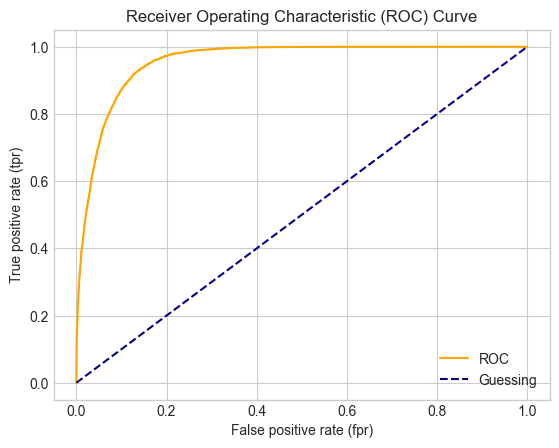


Results on TEST data:


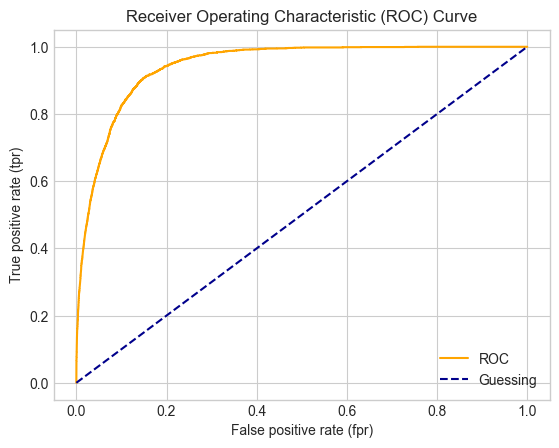

In [212]:
# ROC Curve
print("\nResults on TRAINING data:")
y_train_probs_positive = labelpartial_xgb.predict_proba(X_train)[:,1]
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_probs_positive)
Utility.plot_roc_curve(train_fpr, train_tpr)

print("\nResults on TEST data:")
y_test_probs_positive = labelpartial_xgb.predict_proba(X_test)[:,1]
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_probs_positive)
Utility.plot_roc_curve(test_fpr, test_tpr)

Classification Scores

In [213]:
# Scores
print("\nResults on TRAINING data:")
labelpartialsmote_train_scores = Utility.evaluate_preds(y_train, y_train_pred)

print("\nResults on TEST data:")
labelpartialsmote_test_scores = Utility.evaluate_preds(y_test, y_test_pred)


Results on TRAINING data:
Accuracy            :      89.32%
Precision           :       0.83
Recall              :       0.86
F1 score            :       0.84
F1 (macro) score    :       0.88
F1 (weighted) score :       0.89
ROC-AUC             :       0.88

Results on TEST data:
Accuracy            :      89.25%
Precision           :       0.37
Recall              :       0.79
F1 score            :       0.50
F1 (macro) score    :       0.72
F1 (weighted) score :       0.91
ROC-AUC             :       0.84


Finding: We can see that the model is overfit to the training data given the difference in the TRAINING vs. TEST F1 macro scores, and ROC-AUC values, respectively.  It is surprising how much better base XGBoost does than base and tuned (GridSearch) LogisticRegression and RandomForest models.

The data preparation for this model, which combines "label partial" with SMOTE/UnderSampler, is particularly encouraging.  There is overall a decrease in recall score for TEST data, but a relative increase in precision score for TEST data.  F1 Macro score for TEST data is slightly improved.  ROC_AUC falls on TEST data, but perhaps this tradeoff is OK given the overall harmonized improvement in F1 Macro compared to the previous treatments/preparations for input data.

Of importance note is that in this experiment, the `scale_pos_weight` paramater to account for imbalanced class ratio, was not included in the instantiation of the XGBoostClassifier.  The SMOTE/UnderSampler handled the class imbalance.  What is also nice is that most of the features are one-hot encoded but the ones that add a lot to dimensionality ('hour' and 'weekofyear') were left as label encoded.

Feature Importances

citytype_urban            0.277967
id_gnch                   0.063127
city_Edmonton             0.051889
id_uah                    0.050156
id_fmc                    0.048880
id_rgh                    0.048411
id_mch                    0.041272
hour                      0.036283
id_stollery               0.033502
id_fsch                   0.031463
id_nchc                   0.030293
id_mhrh                   0.025827
id_plc                    0.022984
id_sch                    0.021786
id_crh                    0.021326
dayofweek_Sunday          0.020420
id_shc                    0.018277
id_rdrh                   0.017807
id_rah                    0.016406
dayofweek_Saturday        0.016086
id_dgh                    0.015871
dayperiod_night           0.013162
id_schc                   0.013051
id_lch                    0.012177
id_whc                    0.010680
weekofyear                0.010088
dayofweek_Monday          0.009417
dayofweek_Thursday        0.008407
dayofweek_Wednesday 

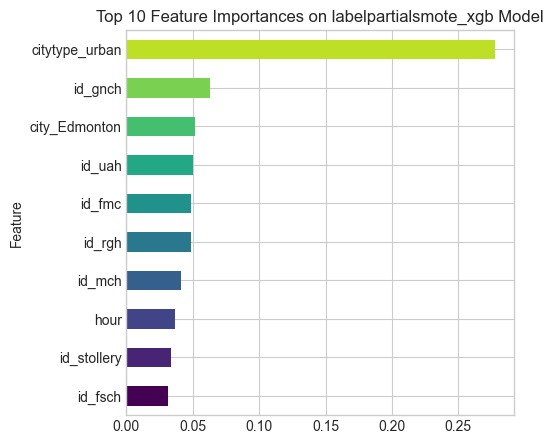

In [214]:
feat_importances = Utility.get_feature_importances_and_plot(labelpartialsmote_xgb, X_train, 'labelpartialsmote_xgb')
display(feat_importances)

# Evaluate performance of all models to this point (6 models)

In [215]:
df_compare = pd.DataFrame({
    'baseline_train': baseline_train_scores,
    'baseline_test': baseline_test_scores,
    'onehot_train': onehot_train_scores,
    'onehot_test': onehot_test_scores,
    'onehot_dropdayperiod_train': onehot_dropdayperiod_train_scores,
    'onehot_dropdayperiod_test': onehot_dropdayperiod_test_scores,
    'labelencoded_train': labelencoded_train_scores,
    'labelencoded_test': labelencoded_test_scores,
    'labelpartial_train': labelpartial_train_scores,
    'labelpartial_test': labelpartial_test_scores,
    'labelpartialsmote_train': labelpartialsmote_train_scores,
    'labelpartialsmote_test': labelpartialsmote_test_scores})

df_compare

,baseline_train,baseline_test,onehot_train,onehot_test,onehot_dropdayperiod_train,onehot_dropdayperiod_test,labelencoded_train,labelencoded_test,labelpartial_train,labelpartial_test,labelpartialsmote_train,labelpartialsmote_test
accuracy,0.90,0.88,0.85,0.84,0.84,0.83,0.87,0.86,0.87,0.86,0.89,0.89
precision,0.39,0.35,0.30,0.29,0.28,0.27,0.34,0.32,0.33,0.32,0.83,0.37
recall,0.98,0.85,0.94,0.88,0.93,0.88,0.95,0.89,0.94,0.90,0.86,0.79
f1,0.56,0.49,0.46,0.44,0.43,0.42,0.50,0.47,0.49,0.47,0.84,0.50
f1_macro,0.75,0.71,0.68,0.67,0.67,0.66,0.71,0.70,0.71,0.70,0.88,0.72
f1_weighted,0.92,0.90,0.88,0.88,0.87,0.87,0.90,0.89,0.89,0.89,0.89,0.91
roc_auc,0.94,0.87,0.89,0.86,0.88,0.85,0.91,0.88,0.90,0.88,0.88,0.84


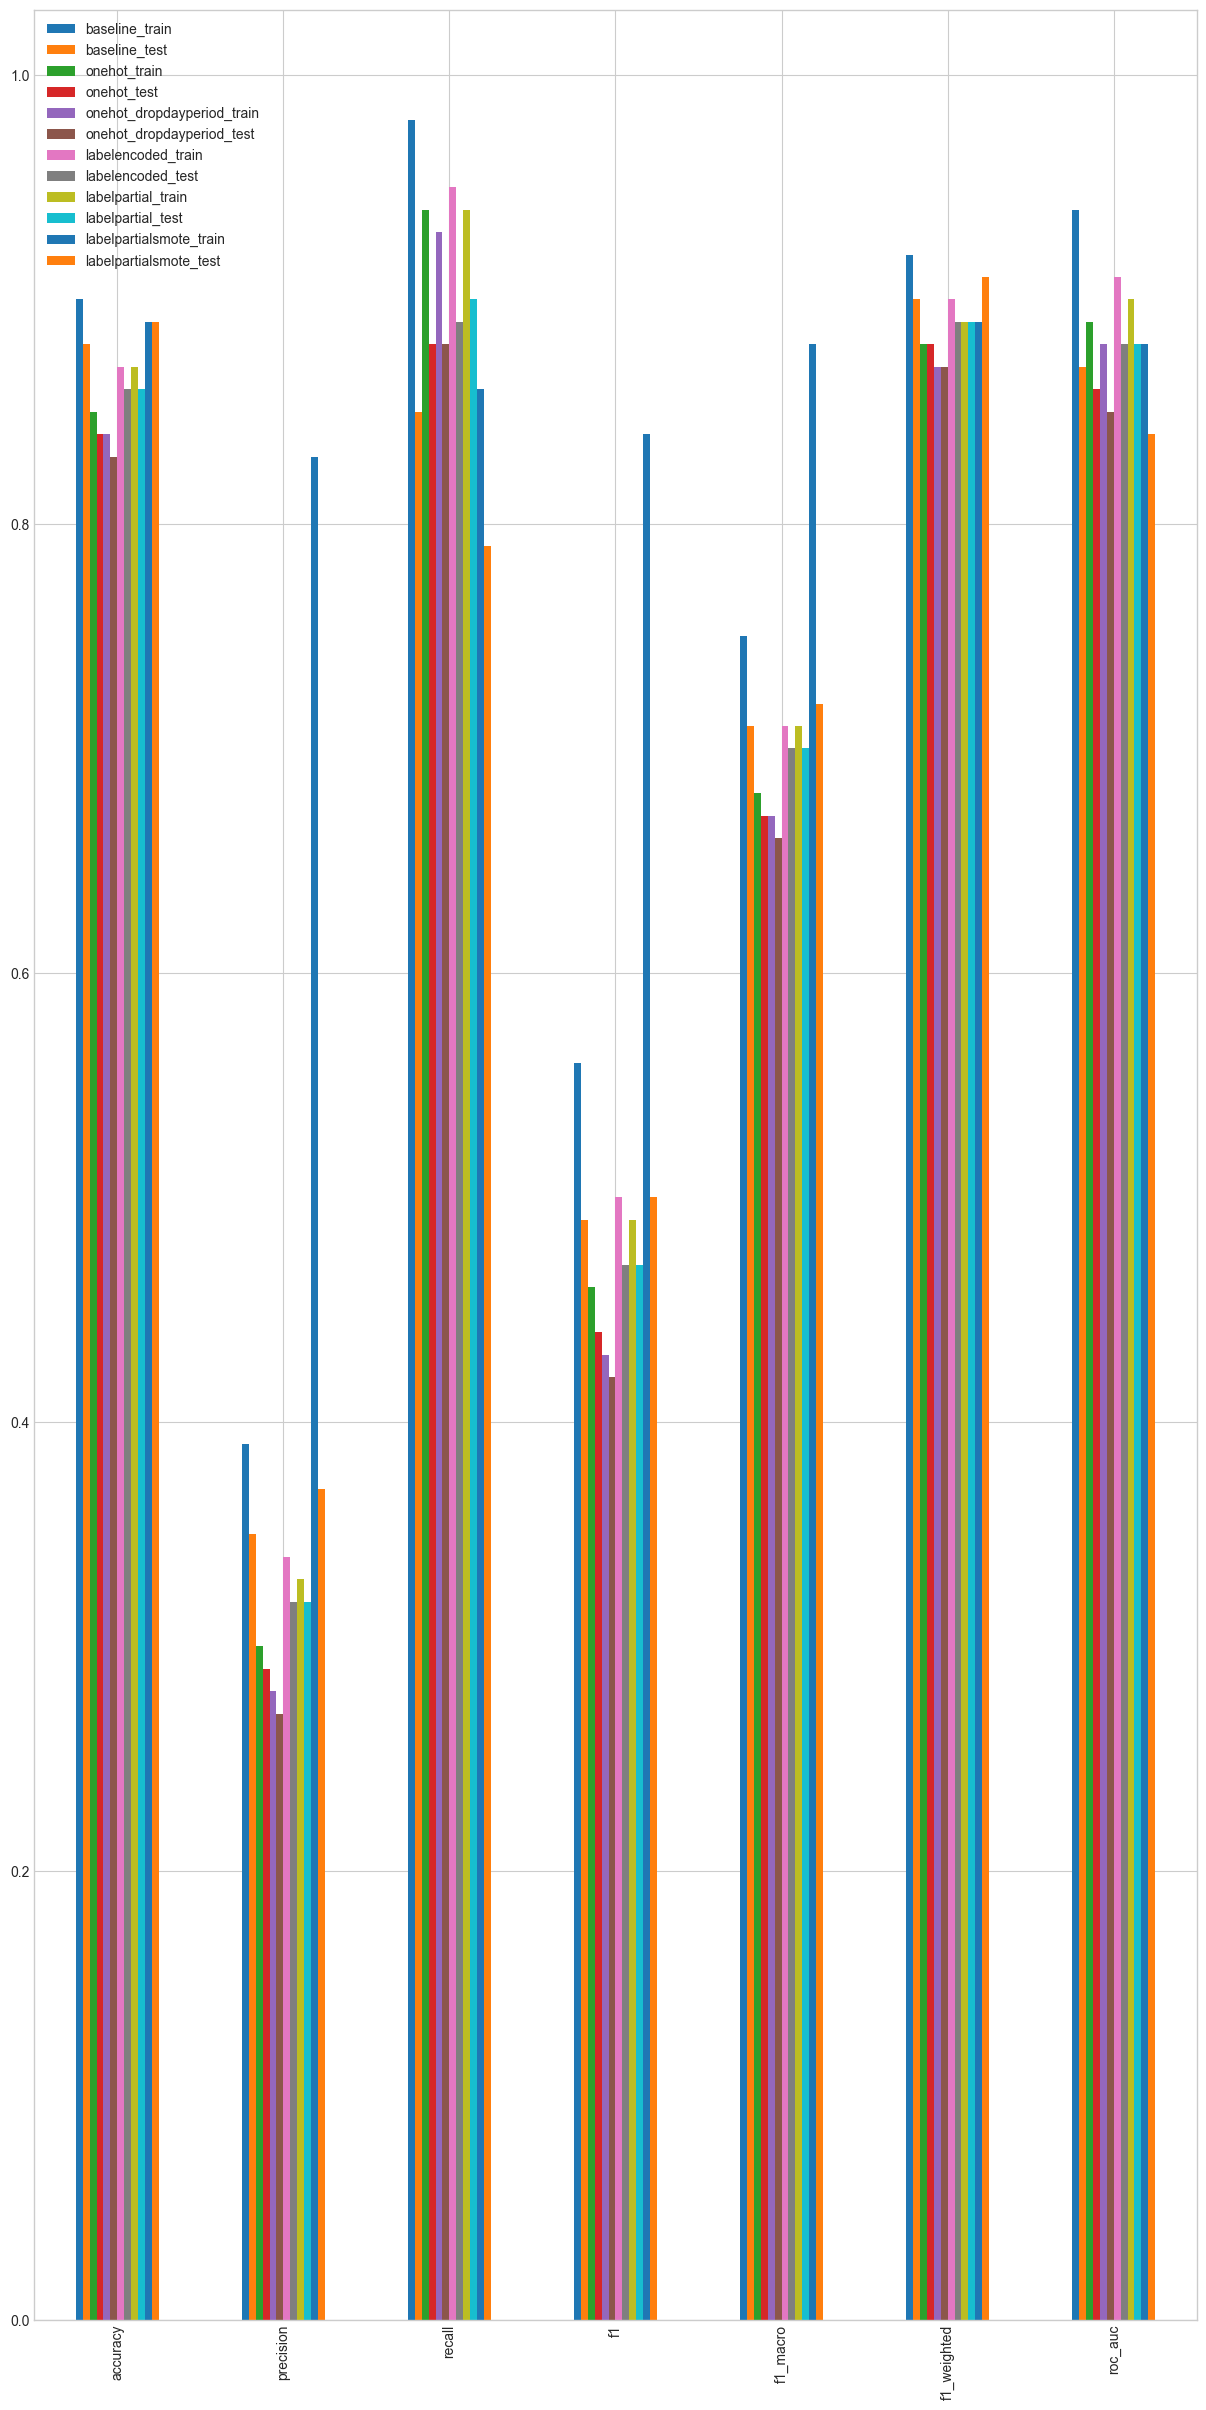

In [216]:
# Plot the scores - TRAINING AND TEST
sns.set_palette("tab10")
df_compare.plot.bar(figsize=(15,30));

Finding:  The above shows that **all** the models are overfit (some significantly), as they do better on TRAINING data than TEST data, and in some cases, drastically better.

Ironically, the `labelencoded` models don't seem to do significantly better in the scores than the baseline where most variables were one-hot encoded, and the 'hour' and 'weekofyear' variables were set to categorical and the `enable_categorical=True` flag was set, which has the XGBoost model do Ordinal Encoding in the background.  In fact, in Accuracy, Precision, and all F1 scores, the "baseline" model and data treatment does better than the label encoded models.seems to generally be equal or slightly better than all the rest of the models on TEST data, for precision, recall, F1 macro and roc_auc.

This makes me wonder if we could get even better scores than the labelpartial_smote, if we did a baseline_smote, and especially if we used `SMOTE` with `sampling_strategy=0.1` and `RandomUnderSampler` with `sampling_strategy=0.5` instead of 0.4 .  This will be a follow on experiment now.

In [217]:
df_compare_test = df_compare.drop(['baseline_train', 'onehot_train', 'onehot_dropdayperiod_train', 'labelencoded_train', 'labelpartial_train', 'labelpartialsmote_train'], axis=1)
df_compare_test

,baseline_test,onehot_test,onehot_dropdayperiod_test,labelencoded_test,labelpartial_test,labelpartialsmote_test
accuracy,0.88,0.84,0.83,0.86,0.86,0.89
precision,0.35,0.29,0.27,0.32,0.32,0.37
recall,0.85,0.88,0.88,0.89,0.90,0.79
f1,0.49,0.44,0.42,0.47,0.47,0.50
f1_macro,0.71,0.67,0.66,0.70,0.70,0.72
f1_weighted,0.90,0.88,0.87,0.89,0.89,0.91
roc_auc,0.87,0.86,0.85,0.88,0.88,0.84


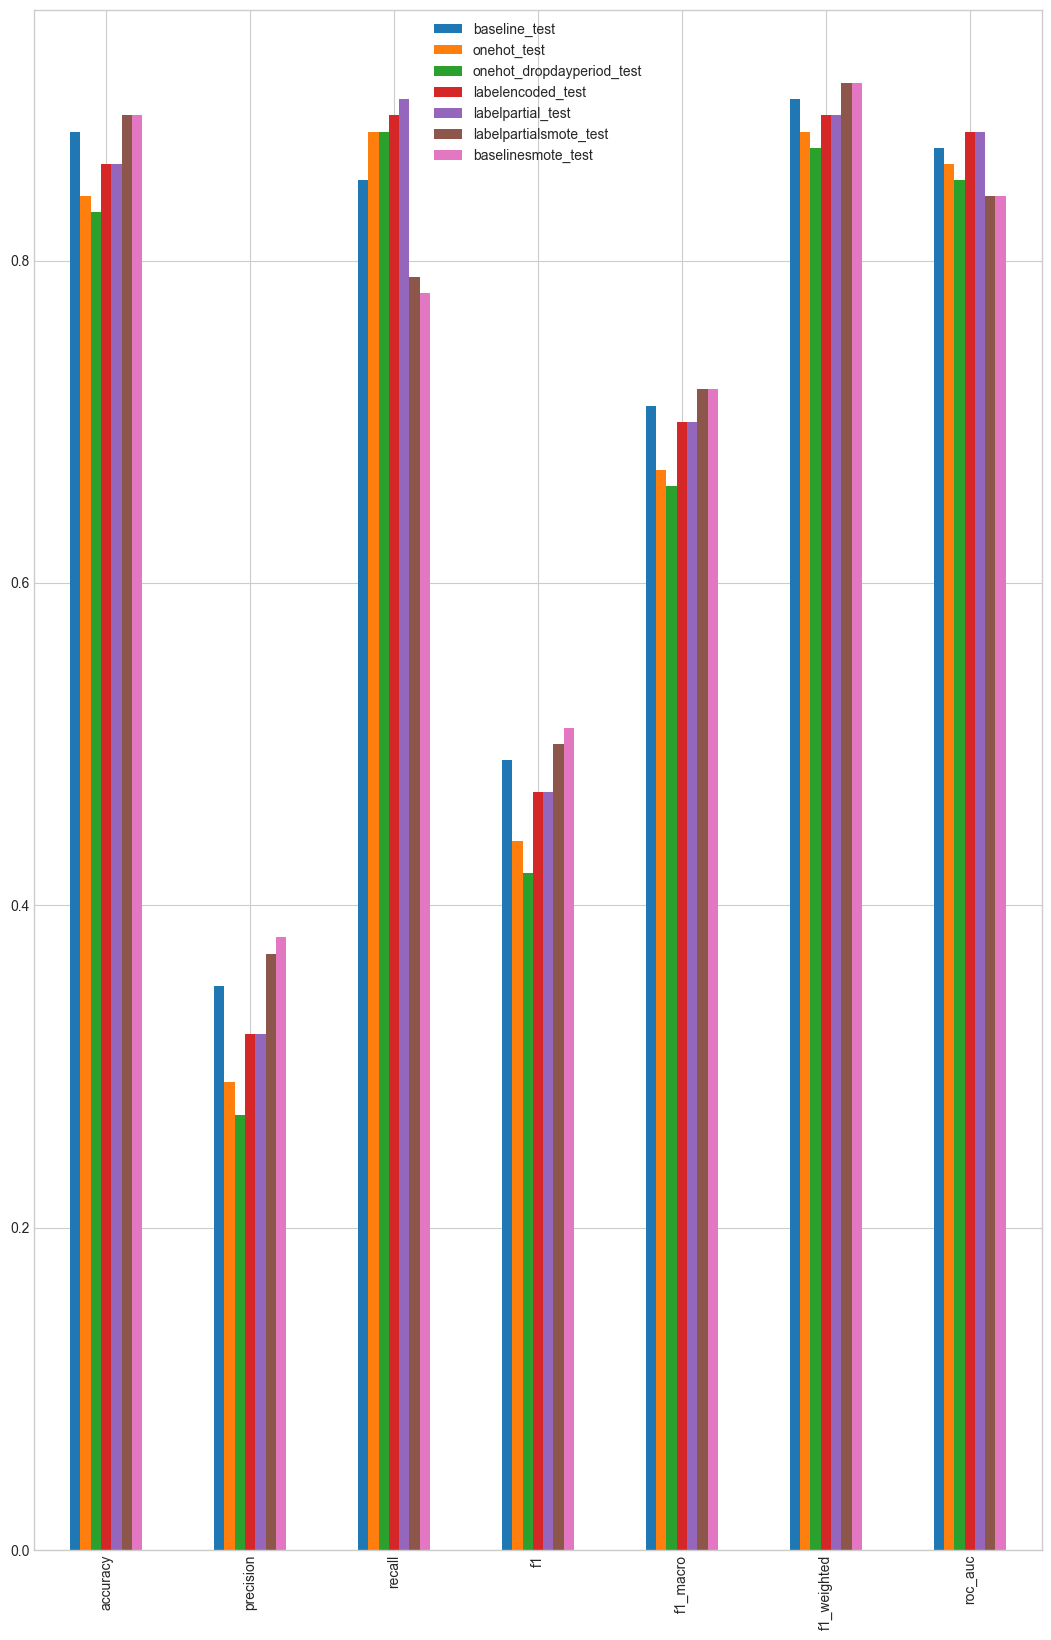

In [267]:
# Plot the scores - TEST ONLY
sns.set_palette("tab10")
df_compare_test.plot.bar(figsize=(13,20));

## Build a 7th model: Build XGBoost model: "baselinesmote"

Coming out of the first 6 models, build a 7th model using input data set up line the "baseline" case, but adding SMOTE/RandomUnderSampler to deal with class imbalance INSTEAD of using `scale_pos_weight` in the classifier.

* Will compare to baseline, labelpartialsmote
* Will use 0.1 and 0.5 sampling strategies for SMOTE and RandomUnderSampler


In [219]:
# One-hot encoding of categorical columns as defined in Utility function (LOGIT_ONEHOT_COLS_A includes 'dayperiod')
df_model_onehot_cols_a = Utility.one_hot_encode_categorical_columns(df_model, Utility.LOGIT_ONEHOT_COLS_A)

# Turn booleans into 0's and 1'
Utility.convert_booleans(df_model_onehot_cols_a)

Convert 'hour' and 'weekofyear' to category types

In [220]:
df_model_onehot_cols_a['hour'] = df_model_onehot_cols_a['hour'].astype('category')
df_model_onehot_cols_a['weekofyear'] = df_model_onehot_cols_a['weekofyear'].astype('category')

How does the dataframe look?

In [221]:
Utility.display_df_general_info(df_model_onehot_cols_a)

,weekofyear,hour,longwait,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,dayperiod_evening,dayperiod_night,id_crh,id_dgh,id_fmc,id_fsch,id_gnch,id_lch,id_mch,id_mhrh,id_nchc,id_plc,id_rah,id_rdrh,id_rgh,id_sch,id_schc,id_shc,id_stollery,id_uah,id_whc,city_Devon,city_Edmonton,city_Fort Saskatchewan,city_Leduc,city_Lethbridge,city_Medicine Hat,city_Red Deer,city_Sherwood Park,city_St. Albert,city_Stony Plain,citytype_urban
0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0



Shape of dataframe:
(181926, 41)

Columns of dataframe:
Index(['weekofyear', 'hour', 'longwait', 'dayofweek_Monday',
       'dayofweek_Saturday', 'dayofweek_Sunday', 'dayofweek_Thursday',
       'dayofweek_Tuesday', 'dayofweek_Wednesday', 'dayperiod_evening',
       'dayperiod_night', 'id_crh', 'id_dgh', 'id_fmc', 'id_fsch', 'id_gnch',
       'id_lch', 'id_mch', 'id_mhrh', 'id_nchc', 'id_plc', 'id_rah', 'id_rdrh',
       'id_rgh', 'id_sch', 'id_schc', 'id_shc', 'id_stollery', 'id_uah',
       'id_whc', 'city_Devon', 'city_Edmonton', 'city_Fort Saskatchewan',
       'city_Leduc', 'city_Lethbridge', 'city_Medicine Hat', 'city_Red Deer',
       'city_Sherwood Park', 'city_St. Albert', 'city_Stony Plain',
       'citytype_urban'],
      dtype='object')

dtypes of dataframe:
weekofyear                category
hour                      category
longwait                     int64
dayofweek_Monday             int32
dayofweek_Saturday           int32
dayofweek_Sunday             int32
dayofwee

## Set X and y dataframes for "baselinesmote" model

In [222]:
X_model = (df_model_onehot_cols_a.drop(['longwait'], axis=1))
y_model = (df_model_onehot_cols_a['longwait'])

## Train-Test Split for Model: "baselinesmote"

In [223]:
# Make 80% training, 20% testing and shuffle the data
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=Utility.RANDOM_STATE_CONST, shuffle=True)

### Need to Oversample the minority class and undersample entire dataset
Code idea/credit: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification

(I made a couple tweaks!)

In [224]:
# Use the same X_train and y_train from the "baseline" code in LogisticRegression notebook, with sampling_strategy 0.1 for SMOTE and 0.5 for RandomUnderSampler, which gives an even better class balance
over = SMOTE(sampling_strategy=0.10, random_state=Utility.RANDOM_STATE_CONST)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=Utility.RANDOM_STATE_CONST)
steps = [('smote', over), ('under', under)]
imbpipeline_sm_under = IMBPipeline(steps=steps)
X_train, y_train = imbpipeline_sm_under.fit_resample(X_train, y_train)

In [225]:
# Check what are the types and numbers in each of the 6 items I just created:
print(f"type(X_model): {type(X_model)}")
print(f"type(y_model): {type(y_model)}")

print(f"type(X_train): {type(X_train)}")
print(f"type(y_train): {type(y_train)}")

print(f"type(X_test): {type(X_test)}")
print(f"type(y_test): {type(y_test)}")

print(f"X_model.shape[0]: {X_model.shape[0]}")
print(f"y_model.shape[0]: {y_model.shape[0]}")

print(f"X_train.shape[0]: {X_train.shape[0]}")
print(f"y_train.shape[0]: {y_train.shape[0]}")

print(f"X_test.shape[0]: {X_test.shape[0]}")
print(f"y_test.shape[0]: {y_test.shape[0]}")

type(X_model): <class 'pandas.core.frame.DataFrame'>
type(y_model): <class 'pandas.core.series.Series'>
type(X_train): <class 'pandas.core.frame.DataFrame'>
type(y_train): <class 'pandas.core.series.Series'>
type(X_test): <class 'pandas.core.frame.DataFrame'>
type(y_test): <class 'pandas.core.series.Series'>
X_model.shape[0]: 181926
y_model.shape[0]: 181926
X_train.shape[0]: 40740
y_train.shape[0]: 40740
X_test.shape[0]: 36386
y_test.shape[0]: 36386


Check class distributions in y_train and y_test after the train_test_split.

This class imbalance is OK.  We will NOT set `class_weights='balanced` in our XGBClassifier

In [226]:
Utility.display_class_balance(y_train, y_test)

y_train_counter: Counter({0: 27160, 1: 13580}), 0: 66.66666666666666, 1: 33.33333333333333
y_test_counter: Counter({0: 33863, 1: 2523}), 0: 93.06601440114329, 1: 6.933985598856703


In [227]:
X_train.dtypes

weekofyear                category
hour                      category
dayofweek_Monday             int32
dayofweek_Saturday           int32
dayofweek_Sunday             int32
dayofweek_Thursday           int32
dayofweek_Tuesday            int32
dayofweek_Wednesday          int32
dayperiod_evening            int32
dayperiod_night              int32
id_crh                       int32
id_dgh                       int32
id_fmc                       int32
id_fsch                      int32
id_gnch                      int32
id_lch                       int32
id_mch                       int32
id_mhrh                      int32
id_nchc                      int32
id_plc                       int32
id_rah                       int32
id_rdrh                      int32
id_rgh                       int32
id_sch                       int32
id_schc                      int32
id_shc                       int32
id_stollery                  int32
id_uah                       int32
id_whc              

In [228]:
baselinesmote_xbg = XGBClassifier(objective='binary:logistic', tree_method='hist', random_state=Utility.RANDOM_STATE_CONST, enable_categorical=True)
baselinesmote_xbg.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [229]:
# Get predictions for X_train and X_test
y_train_pred = baselinesmote_xbg.predict(X_train)
y_test_pred = baselinesmote_xbg.predict(X_test)

## Evaluate model performance: "baselinesmote"

Confusion Matrix

In [230]:
# Confusion Matrix
print("\nResults on TRAINING data:")
baselinesmote_train_cm = Utility.print_confusion_matrix_with_labels(y_train, y_train_pred)

print("\nResults on TEST data:")
baselinesmote_test_cm = Utility.print_confusion_matrix_with_labels(y_test, y_test_pred)


Results on TRAINING data:


,Predicted Positive,Predicted Negative
Actual Positive,12290,1290
Actual Negative,1979,25181



Results on TEST data:


,Predicted Positive,Predicted Negative
Actual Positive,1970,553
Actual Negative,3279,30584


ROC Curve


Results on TRAINING data:


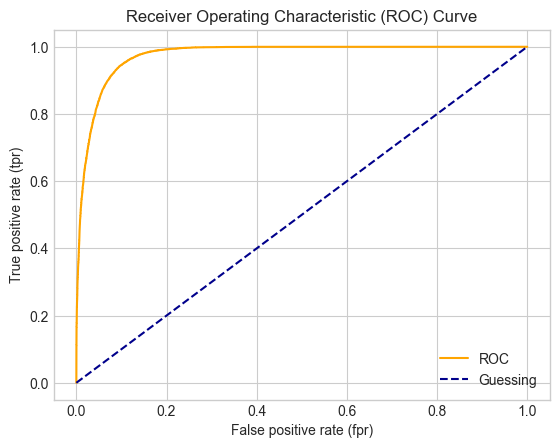


Results on TEST data:


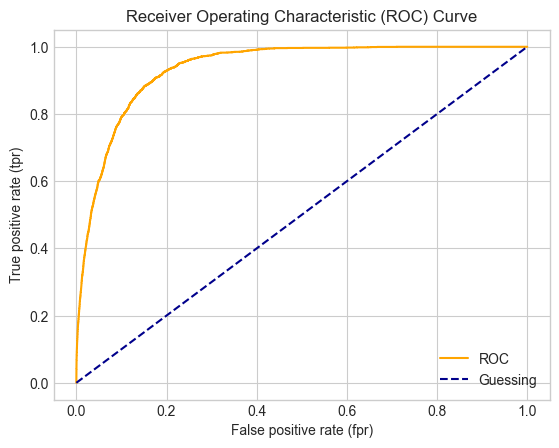

In [231]:
# ROC Curve
print("\nResults on TRAINING data:")
y_train_probs_positive = baselinesmote_xbg.predict_proba(X_train)[:,1]
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_probs_positive)
Utility.plot_roc_curve(train_fpr, train_tpr)

print("\nResults on TEST data:")
y_test_probs_positive = baselinesmote_xbg.predict_proba(X_test)[:,1]
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_probs_positive)
Utility.plot_roc_curve(test_fpr, test_tpr)

Classification Scores

In [232]:
# Scores
print("\nResults on TRAINING data:")
baselinesmote_train_scores = Utility.evaluate_preds(y_train, y_train_pred)

print("\nResults on TEST data:")
baselinesmote_test_scores = Utility.evaluate_preds(y_test, y_test_pred)


Results on TRAINING data:
Accuracy            :      91.98%
Precision           :       0.86
Recall              :       0.91
F1 score            :       0.88
F1 (macro) score    :       0.91
F1 (weighted) score :       0.92
ROC-AUC             :       0.92

Results on TEST data:
Accuracy            :      89.47%
Precision           :       0.38
Recall              :       0.78
F1 score            :       0.51
F1 (macro) score    :       0.72
F1 (weighted) score :       0.91
ROC-AUC             :       0.84


Feature Importances

citytype_urban            0.300043
id_gnch                   0.068707
city_Edmonton             0.046999
id_fmc                    0.041593
id_rgh                    0.040646
hour                      0.037552
id_uah                    0.037107
id_plc                    0.033482
id_mhrh                   0.033326
id_mch                    0.032956
id_nchc                   0.029234
id_crh                    0.028822
id_stollery               0.028660
id_dgh                    0.023953
id_fsch                   0.023246
id_sch                    0.020250
id_rdrh                   0.018550
weekofyear                0.017943
id_rah                    0.017243
id_lch                    0.016542
dayofweek_Sunday          0.015612
id_shc                    0.015045
id_schc                   0.013811
dayofweek_Saturday        0.011617
id_whc                    0.008743
dayofweek_Monday          0.007540
dayperiod_night           0.006934
dayofweek_Thursday        0.006881
dayofweek_Tuesday   

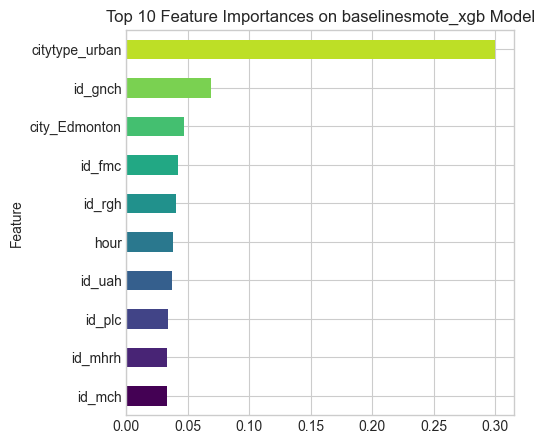

In [233]:
feat_importances = Utility.get_feature_importances_and_plot(baselinesmote_xbg, X_train, 'baselinesmote_xgb')
display(feat_importances)

# Compare results of baseline vs. baselinesmote vs. labelpartialsmote

In [234]:
# Recall that up to this point, the df_compare dataframe with all score results, looks like this:
#df_compare = pd.DataFrame({
#    'baseline_train': baseline_train_scores,
#    'baseline_test': baseline_test_scores,
#    'onehot_train': onehot_train_scores,
#    'onehot_test': onehot_test_scores,
#    'onehot_dropdayperiod_train': onehot_dropdayperiod_train_scores,
#    'onehot_dropdayperiod_test': onehot_dropdayperiod_test_scores,
#    'labelencoded_train': labelencoded_train_scores,
#    'labelencoded_test': labelencoded_test_scores,
#    'labelpartial_train': labelpartial_train_scores,
#    'labelpartial_test': labelpartial_test_scores,
#    'labelpartialsmote_train': labelpartialsmote_train_scores,
#    'labelpartialsmote_test': labelpartialsmote_test_scores})

df_compare['baselinesmote_train'] = baselinesmote_train_scores
df_compare['baselinesmote_test'] = baselinesmote_test_scores

In [235]:
# Recall:
#df_compare_test = df_compare.drop(['baseline_train', 'onehot_train', 'onehot_dropdayperiod_train', 'labelencoded_train', 'labelpartial_train', 'labelpartialsmote_train'], axis=1)

df_compare_test['baselinesmote_test'] = baselinesmote_test_scores

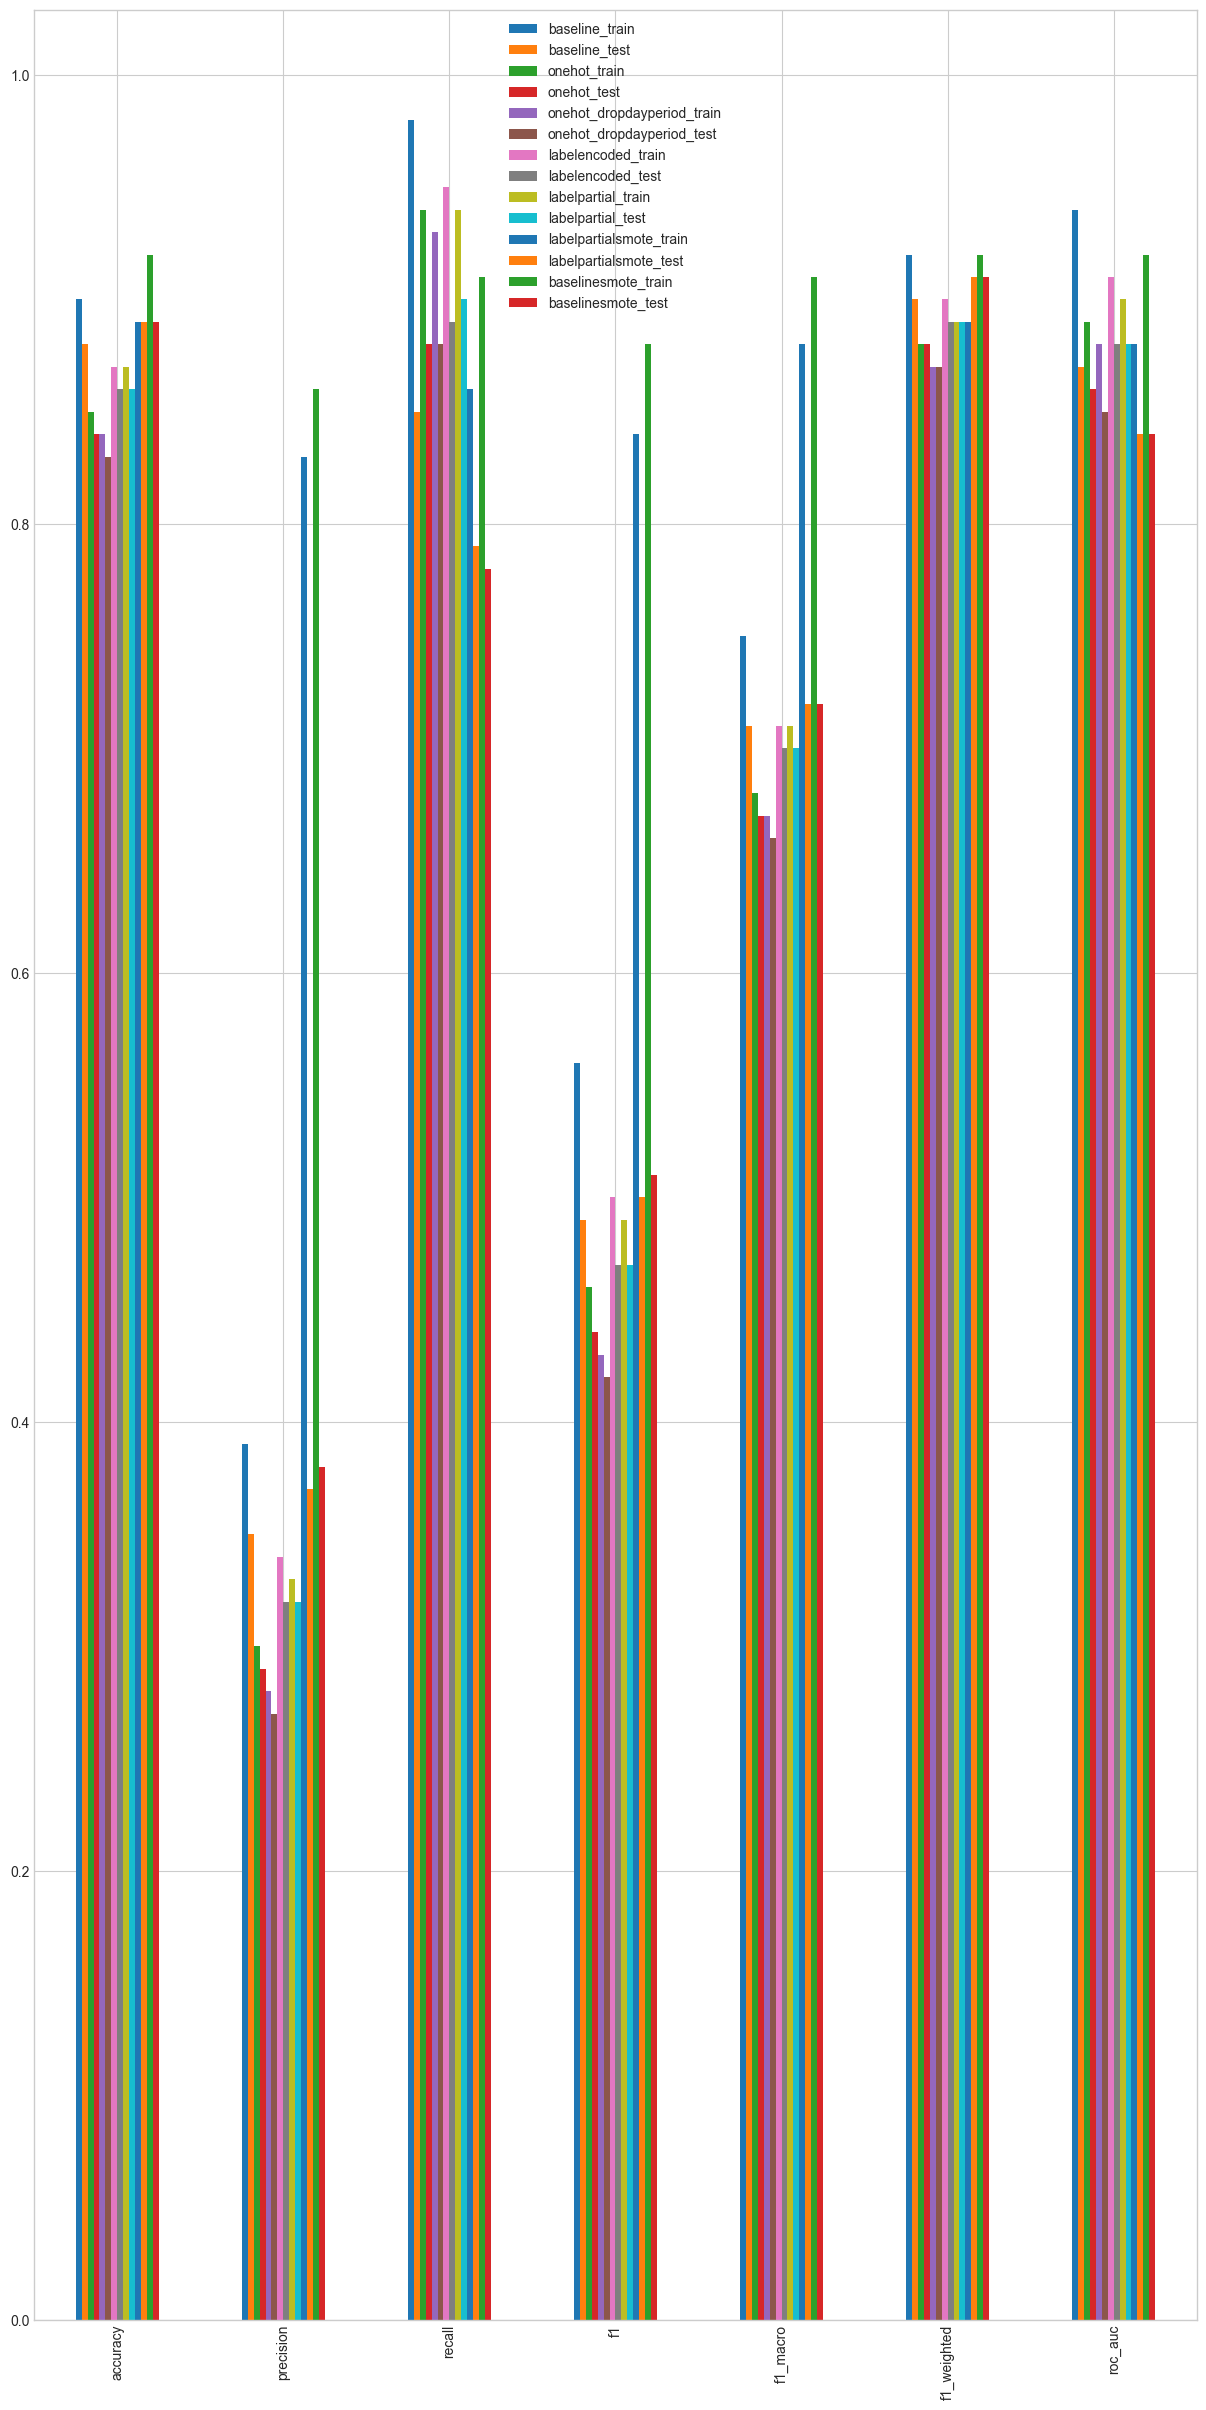

In [236]:
# Plot the scores - TRAINING AND TEST
sns.set_palette("tab10")
df_compare.plot.bar(figsize=(15,30));

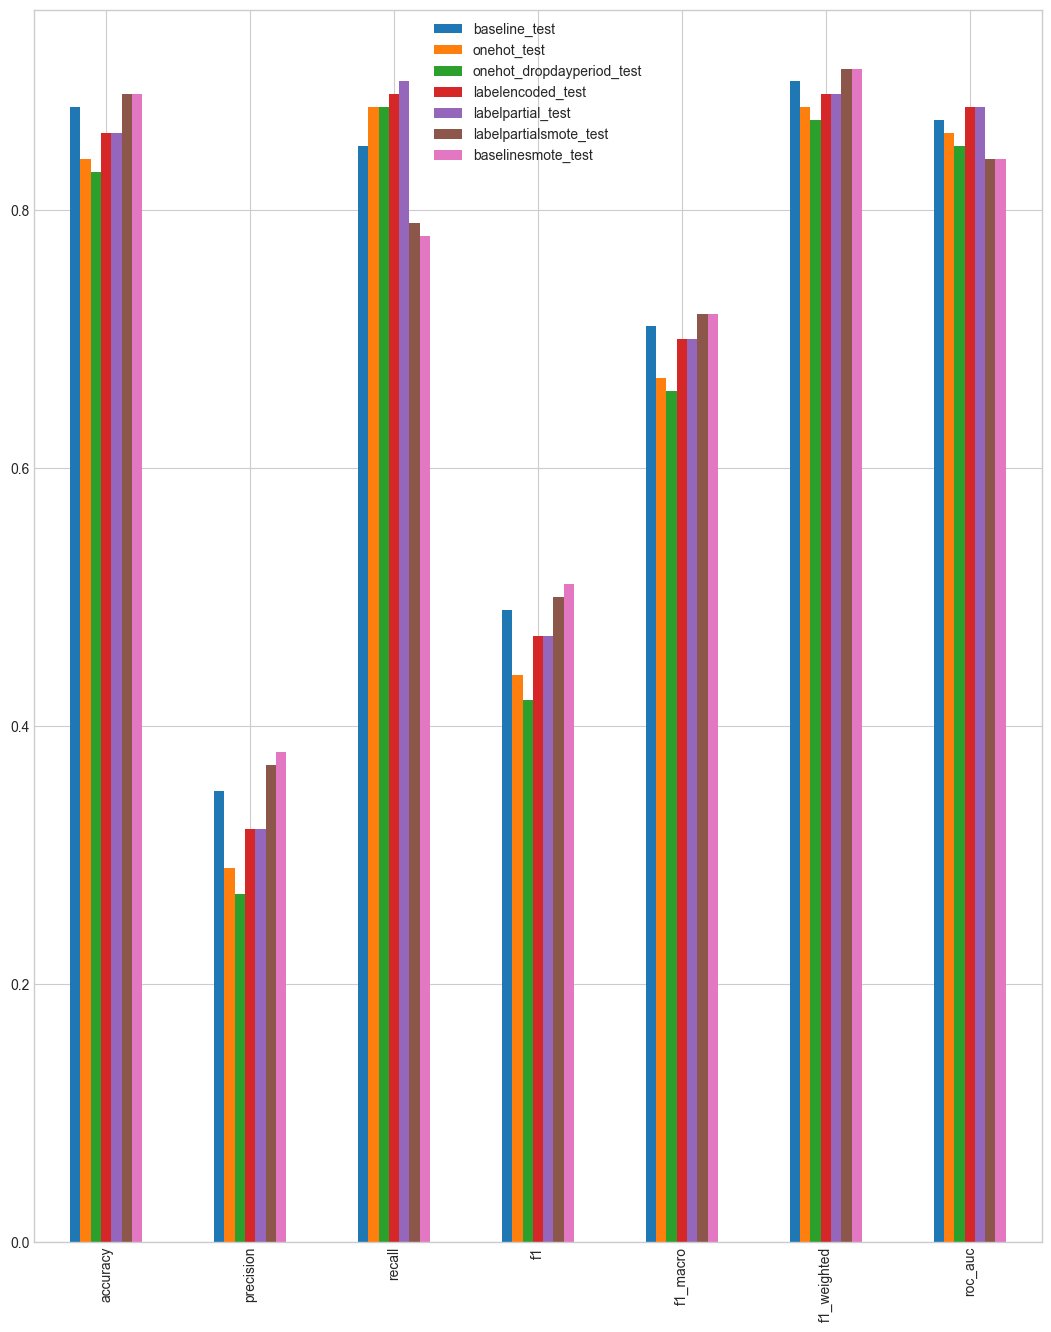

In [237]:
# Plot the scores - TEST ONLY
sns.set_palette("tab10")
df_compare_test.plot.bar(figsize=(13,16));

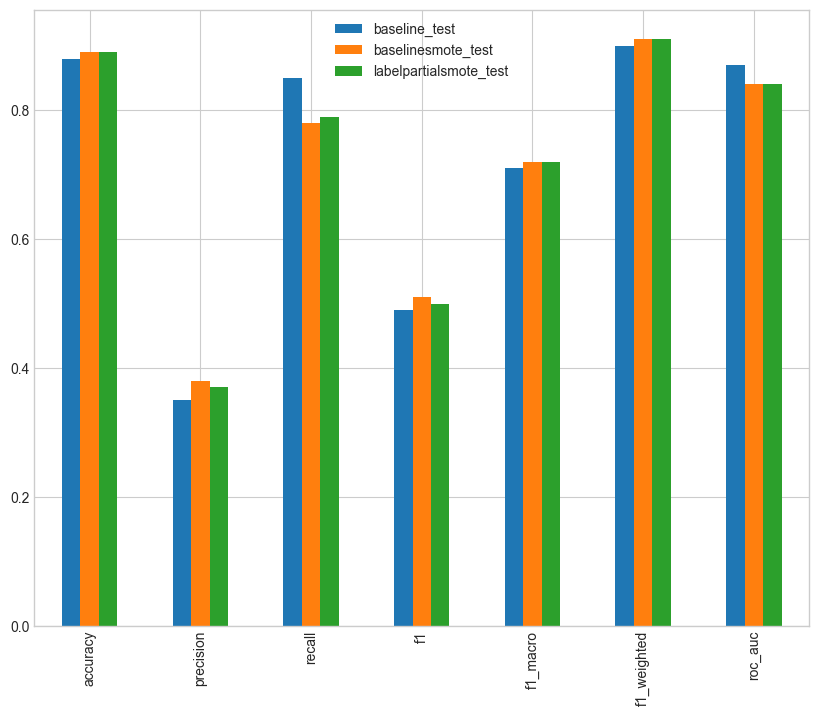

In [238]:
# Let's look at just baseline, baselinesmote, and labelpartialsmote plots
# Plot the scores - TEST ONLY
sns.set_palette("tab10")
df_compare_test[['baseline_test', 'baselinesmote_test', 'labelpartialsmote_test']].plot.bar(figsize=(10,8));

Findings: **labelpartialsmote** is the best treatment overall with the best overall scores.

It is the highest for accuracy, precision, macro F1, weighted F1.  It is 2nd place on Recall and regular F1 and roc_auc.

There appears to be a bit of a tradeoff between precision and recall, in that for a precision gain, we lose some in recall.

This "labelpartialsmote" data preparation is the most promising if we wanted to do a GridSearchCV to attempt to hyperparameter tune and try to squeeze better performance out of the XGBoost model type.

# Can We Do Better on XGBoost Model?

Can we run this dataset in a GridSearchCV, using an exhaustive search against the various hyperparameters for the XGBoost, and scoring to be `f1_score`, that may help with the overfitting?

3 separate GridSearchCV executions were completed, 2 on Google Colab to take advantage of the GPU.

1. Run #1: The 1st set of hyperparameters resulted in best_estimator_ that performed much worse than all of the base models prior.
2. Run #2: The 2nd set of executions resulted in the best performance over all
3. Run #3: The 3rd set of executions resulted in better performance than the base models, but worse than the 2nd set of executions.

The `best_params_` for 2nd and 3rd executions are displayed below.

We will do scores comparisons with the GridSearch Run #2 `best_estimator_` and GridSearch Run #3 `best_estimator_`:
* The 2nd run's best model .pkl save was lost when the Google Colab runtime closed while being unattended. Therefore, the 2nd run's `best_params_` will be used to reconstruct an XGBoostClassifier model for the grid_search execution #2.
* The Grid Search Run #3 `best_params_` will also be used to reconstruct an XGBoostClassifier model for best model for the grid_search execution #3.  While a .pkl file was saved from Google Colab, the XGBoost versions between here and Google Colab (1.7.3 vs. 2.0.2, respectively) mean there is a mismatch, and there are errors de-serializing the grid_search saved from Colab to here.

Please see file `erwait_model_xgboost_GridSearch3rdrun_Google_Colab.ipynb` to see the execution of the Google Colab's execution of Grid Search Run #3.

### Grid Search Run #2:

This is the information from Google Colab execution these were the values that were achieved on Google Colab with 2nd execution params:

2nd run params:
```
param_grid = {
    "max_depth": [6, 7, 9],                    # Control model complexity (overfitting)
    "learning_rate": [0.05, 0.1, 0.2],         # Affects the rate at which the model learns
    "gamma": [0, 0.1, 0.2],                    # Regularization (complexity control)
    "reg_lambda": [0.5, 1, 3],                 # L2 regularization (reduce overfitting)
    "scale_pos_weight": [2, 2.5, 3],           # Address class imbalance
    "subsample": [0.7, 0.8, 0.9],              # Control overfitting by changing the sample of data
    "colsample_bytree": [0.4, 0.5, 0.6]        # Control overfitting by changing the sample of features
}
```

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits

```
grid_search.best_params_

{'colsample_bytree': 0.6,
 'gamma': 0.1,
 'learning_rate': 0.2,
 'max_depth': 9,
 'reg_lambda': 0.5,
 'scale_pos_weight': 2,
 'subsample': 0.8}
```

```
grid_search.best_score_

0.8624813785144008
```

```
# Scores
print("\nResults on TRAINING data:")
gridbest_train_scores = Utility.evaluate_preds(y_train, y_train_pred)

print("\nResults on TEST data:")
gridbest_test_scores = Utility.evaluate_preds(y_test, y_test_pred)

Results on TRAINING data:
Accuracy            :      91.09%
Precision           :       0.81
Recall              :       0.96
F1 score            :       0.88
F1 (macro) score    :       0.90
F1 (weighted) score :       0.91
ROC-AUC             :       0.92

Results on TEST data:
Accuracy            :      86.71%
Precision           :       0.33
Recall              :       0.88
F1 score            :       0.48
F1 (macro) score    :       0.70
F1 (weighted) score :       0.89
ROC-AUC             :       0.87
```

### Grid Search Run #3:

This is the information from Google Colab execution these were the values that were achieved on Google Colab with 2nd execution params:

3rd run params:

```
param_grid = {
    "max_depth": [6, 7, 8],                    # Decrease max_depth to prevent overfit
    "learning_rate": [0.1, 0.15],              # Decrease learning_rate to slow down learning
    "gamma": [0.1, 0.3],                       # Moderate gamma values
    "reg_lambda": [0.5, 1, 2],                 # Increase regularization
    "scale_pos_weight": [1.5, 2],              # Fine-tune class balance
    "subsample": [0.75, 0.8, 0.85],            # Adjust subsample
    "colsample_bytree": [0.5, 0.6, 0.7]        # Adjust feature subsample
}
```

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [17:20:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)

```
grid_search.best_params_

{'colsample_bytree': 0.7,
 'gamma': 0.3,
 'learning_rate': 0.15,
 'max_depth': 8,
 'reg_lambda': 0.5,
 'scale_pos_weight': 1.5,
 'subsample': 0.8}
```

```
grid_search.best_score_
0.8575204044886121
```

```
# Scores
print("\nResults on TRAINING data:")
gridbest_train_scores = Utility.evaluate_preds(y_train, y_train_pred)

print("\nResults on TEST data:")
gridbest_test_scores = Utility.evaluate_preds(y_test, y_test_pred)

Results on TRAINING data:
Accuracy            :      89.71%
Precision           :       0.80
Recall              :       0.92
F1 score            :       0.86
F1 (macro) score    :       0.89
F1 (weighted) score :       0.90
ROC-AUC             :       0.90

Results on TEST data:
Accuracy            :      87.04%
Precision           :       0.33
Recall              :       0.86
F1 score            :       0.48
F1 (macro) score    :       0.70
F1 (weighted) score :       0.89
ROC-AUC             :       0.86
```

### To set up data for Grid Search Run #2 and Run #3 scores capture:

Ensure everything is set up from base, for 'labelpartialsmote' situation!

We will build a model using data set up same as "LabelPartial", but with SMOTE and RandomUnderSampler (sampling_strategy=0.1 and 0.5, respectively, as those were used on basic LogisticRegression) and `scale_pos_weight` set appropriately after the splits.

In [239]:
# Make a copy of df_model first
df_model_labelpartial = df_model.copy()

# One-hot encoding of categorical columns as defined in Utility function (LOGIT_ONEHOT_COLS_A includes 'dayperiod')
df_model_labelpartial = Utility.one_hot_encode_categorical_columns(df_model_labelpartial, Utility.LOGIT_ONEHOT_COLS_A)

# Turn booleans into 0's and 1'
Utility.convert_booleans(df_model_labelpartial)

# Label Encode 'hour' and 'weekofyear'
label_encoder = LabelEncoder()
for column in ['hour', 'weekofyear']:
    df_model_labelpartial[column] = label_encoder.fit_transform(df_model_labelpartial[column])

## Set X and y dataframes for "labelpartialsmote" model for Grid Search #2 and #3 scores evaluation.

In [240]:
X_model = (df_model_labelpartial.drop(['longwait'], axis=1))
y_model = (df_model_labelpartial['longwait'])

## Train-Test Split for Model: "labelpartialsmote" for Grid Search #2 and #3 scores evaluation.

In [241]:
# Make 80% training, 20% testing and shuffle the data
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=Utility.RANDOM_STATE_CONST, shuffle=True)

### Need to Oversample the minority class and undersample entire dataset
Code idea/credit: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification

(I made a couple tweaks!)

In [242]:
# Use the same X_train and y_train from the "baseline" code in LogisticRegression notebook, with sampling_strategy 0.1 for SMOTE and 0.5 for RandomUnderSampler
over = SMOTE(sampling_strategy=0.10, random_state=Utility.RANDOM_STATE_CONST)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=Utility.RANDOM_STATE_CONST)  # Best params from Logit Grid Search
steps = [('smote', over), ('under', under)]
imbpipeline_sm_under = IMBPipeline(steps=steps)
X_train, y_train = imbpipeline_sm_under.fit_resample(X_train, y_train)

In [243]:
# Check what are the types and numbers in each of the 6 items I just created:
print(f"type(X_model): {type(X_model)}")
print(f"type(y_model): {type(y_model)}")

print(f"type(X_train): {type(X_train)}")
print(f"type(y_train): {type(y_train)}")

print(f"type(X_test): {type(X_test)}")
print(f"type(y_test): {type(y_test)}")

print(f"X_model.shape: {X_model.shape}")
print(f"y_model.shape: {y_model.shape}")

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")

print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

type(X_model): <class 'pandas.core.frame.DataFrame'>
type(y_model): <class 'pandas.core.series.Series'>
type(X_train): <class 'pandas.core.frame.DataFrame'>
type(y_train): <class 'pandas.core.series.Series'>
type(X_test): <class 'pandas.core.frame.DataFrame'>
type(y_test): <class 'pandas.core.series.Series'>
X_model.shape: (181926, 40)
y_model.shape: (181926,)
X_train.shape: (40740, 40)
y_train.shape: (40740,)
X_test.shape: (36386, 40)
y_test.shape: (36386,)


Check class distributions in y_train and y_test after the train_test_split.

For this class imbalance, we will experiment in the GridSearch with different `scale_pos_weight` parameters on the XGBClassifier, including the default which is `1` and also the `scale_pos_weight` set in the below cells, for the recommended majority/minority class ratio.

In [244]:
Utility.display_class_balance(y_train, y_test)

y_train_counter: Counter({0: 27160, 1: 13580}), 0: 66.66666666666666, 1: 33.33333333333333
y_test_counter: Counter({0: 33863, 1: 2523}), 0: 93.06601440114329, 1: 6.933985598856703


In [245]:
# Set new scale_pos_weight based on above numbers
# 0: 66.66666666666666, 1: 33.33333333333333

# As suggested by XGBoost documentation (https://xgboost.readthedocs.io/en/stable/parameter.html),
# set this to sum(majority_class)/sum(minority_class)
scale_pos_weight = float(66.67/33.33)
scale_pos_weight

2.0003000300030003

### GridSearchCV was done for Run #1, Run #2 and Run #3.

See file `erwait_model_xgboost_GridSearch3rdrun_Google_Colab.ipynb` for a recording of Run #3 on Google Colab, and for more details about the hyperparameters used in each run.

Define GridSearchCV with:
* param_grid with hyperparameters as defined in cells below
* XGBClassifier instantiated with Utility.RANDOM_STATE_CONST, tree_method='hist', device='cuda', predictor='gpu_predictor' <-- This was for GPU usage on Google colab
* `scoring = 'f1_macro'`
* `n_jobs = -1`
* `verbose=2`
* `cv=5`

Useful information about each of the hyperparameters being tuned for XGBoost
(Credit: Lighthouse Labs' "LarryBot" chatbot):

* max_depth: This controls the depth of the tree. Greater depth can increase the model's ability to capture more complex patterns but can also lead to overfitting.
* learning_rate: This is a shrinkage parameter that helps in preventing overfitting by making the boosting process more conservative.
* gamma: This is the minimum loss reduction required to make a further partition on a leaf node of the tree, serving as a complexity control.
* reg_lambda: This is the L2 regularization term on weights, which can discourage large weights and thus control overfitting.
* scale_pos_weight: Used to balance the classes in an imbalanced dataset.
* subsample: The fraction of samples to be used for fitting the individual base learners. Setting it to 0.8 means that each tree will be trained on 80% of the data.
* colsample_bytree: The fraction of features to be used for each tree. A lower value can provide more diversity in the trees.

### The below is commented out code that shows what was run for Run #1, #2 and #3

In [246]:
# Instantiate RFC classifier object

# Run #1
# xgb = XGBClassifier(random_state=Utility.RANDOM_STATE_CONST)

# Run #2 and #3
# xgb = XGBClassifier(random_state=Utility.RANDOM_STATE_CONST, tree_method='hist', device='cuda', predictor='gpu_predictor') # For GPU.  Note tree_method='gpu_hist' has been deprecated.

# Define the param_grid for GridSearchCV

# Run #1 used:
# param_grid = {
#     "tree_method" : ['hist'],
#     "device" : ['gpu'], # Needs to be commented out if not running on Google Colab
#     "max_depth": [3, 4, 5, 7],
#     "learning_rate": [0.1, 0.01, 0.05],
#     "gamma": [0, 0.25, 1],
#     "reg_lambda": [0, 1, 10],
#     "scale_pos_weight": [1, 3, 5, scale_pos_weight],
#     "subsample": [0.8],
#     "colsample_bytree": [0.5]
# }

# Run #2 suggested by Larry Bot and resulted in the best-performing model overall:
# param_grid = {
#     "max_depth": [6, 7, 9],                    # Control model complexity (overfitting)
#     "learning_rate": [0.05, 0.1, 0.2],         # Affects the rate at which the model learns
#     "gamma": [0, 0.1, 0.2],                    # Regularization (complexity control)
#     "reg_lambda": [0.5, 1, 3],                 # L2 regularization (reduce overfitting)
#     "scale_pos_weight": [2, 2.5, 3],           # Address class imbalance
#     "subsample": [0.7, 0.8, 0.9],              # Control overfitting by changing the sample of data
#     "colsample_bytree": [0.4, 0.5, 0.6]        # Control overfitting by changing the sample of features
# }

# Run #3
# param_grid = {
#     "max_depth": [6, 7, 8],                    # Decrease max_depth to prevent overfit
#     "learning_rate": [0.1, 0.15],              # Decrease learning_rate to slow down learning 
#     "gamma": [0.1, 0.3],                       # Moderate gamma values
#     "reg_lambda": [0.5, 1, 2],                 # Increase regularization
#     "scale_pos_weight": [1.5, 2],              # Fine-tune class balance
#     "subsample": [0.75, 0.8, 0.85],            # Adjust subsample
#     "colsample_bytree": [0.5, 0.6, 0.7]        # Adjust feature subsample
# }

# GridSearch complete (using GPUs from Google Colab) outside this notebook

# Rebuild Grid Search Run #2 best model (`gridbest2`) from GridSearchCV run #2 `best_params_`:

Grid Search Run #2 was the best overall, and was generated using Google Colab GPU. The pickle file was stored in the local Colab environment and was lost when the runtime timed out.

We will rebuild it locally to be able to show the comparative scores results on the plots.

Grid Search Run #2 `best_params_`:
```
{'colsample_bytree': 0.6,
 'gamma': 0.1,
 'learning_rate': 0.2,
 'max_depth': 9,
 'reg_lambda': 0.5,
 'scale_pos_weight': 2,
 'subsample': 0.8}
```

In [247]:
# Set up string representation of the best_params_ object:
run2_parms_str = """
{'colsample_bytree': 0.6,
'gamma': 0.1,
'learning_rate': 0.2,
'max_depth': 9,
'reg_lambda': 0.5,
'scale_pos_weight': 2,
'subsample': 0.8}
"""

# Make the above into a dictionary
run2_parms_dict = eval(run2_parms_str)

# Instantiate an XGBClassifier with the same parameters
gridbest2_xgb = XGBClassifier(random_state=Utility.RANDOM_STATE_CONST, tree_method='hist', **run2_parms_dict)

In [248]:
# Fit the model
gridbest2_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

## Evaluate model performance: "gridbest2"

In [249]:
# Get preds from grid_search.best_estimator_
y_train_pred = gridbest2_xgb.predict(X_train)
y_test_pred = gridbest2_xgb.predict(X_test)

Confusion Matrix

In [250]:
# Confusion Matrix
print("\nResults on TRAINING data:")
gridbest2_train_cm = Utility.print_confusion_matrix_with_labels(y_train, y_train_pred)

print("\nResults on TEST data:")
gridbest2_test_cm = Utility.print_confusion_matrix_with_labels(y_test, y_test_pred)


Results on TRAINING data:


,Predicted Positive,Predicted Negative
Actual Positive,13064,516
Actual Negative,3177,23983



Results on TEST data:


,Predicted Positive,Predicted Negative
Actual Positive,2242,281
Actual Negative,4584,29279


ROC Curve


Results on TRAINING data:


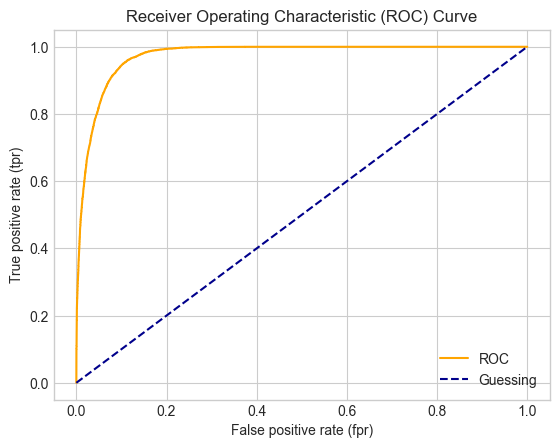


Results on TEST data:


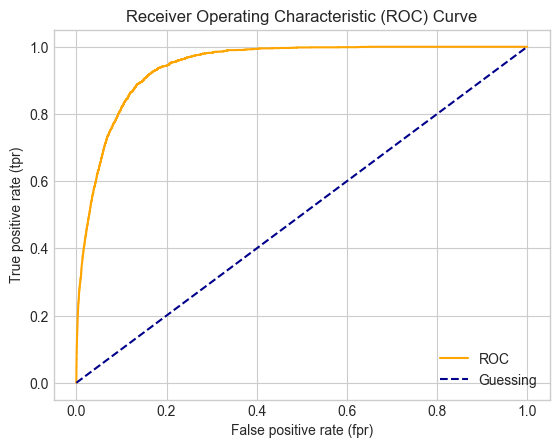

In [251]:
# ROC Curve
print("\nResults on TRAINING data:")
y_train_probs_positive = gridbest2_xgb.predict_proba(X_train)[:,1]
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_probs_positive)
Utility.plot_roc_curve(train_fpr, train_tpr)

print("\nResults on TEST data:")
y_test_probs_positive = gridbest2_xgb.predict_proba(X_test)[:,1]
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_probs_positive)
Utility.plot_roc_curve(test_fpr, test_tpr)

Classification Scores

In [252]:
# Scores
print("\nResults on TRAINING data:")
gridbest2_train_scores = Utility.evaluate_preds(y_train, y_train_pred)

print("\nResults on TEST data:")
gridbest2_test_scores = Utility.evaluate_preds(y_test, y_test_pred)


Results on TRAINING data:
Accuracy            :      90.94%
Precision           :       0.80
Recall              :       0.96
F1 score            :       0.88
F1 (macro) score    :       0.90
F1 (weighted) score :       0.91
ROC-AUC             :       0.92

Results on TEST data:
Accuracy            :      86.63%
Precision           :       0.33
Recall              :       0.89
F1 score            :       0.48
F1 (macro) score    :       0.70
F1 (weighted) score :       0.89
ROC-AUC             :       0.88


Feature Importances

id_mhrh                   0.073123
city_Lethbridge           0.066604
id_gnch                   0.066237
city_Medicine Hat         0.055839
dayperiod_night           0.053574
id_crh                    0.039784
citytype_urban            0.039288
id_dgh                    0.038348
city_Devon                0.036417
id_lch                    0.035061
city_Fort Saskatchewan    0.032852
id_plc                    0.030195
dayperiod_evening         0.028442
id_stollery               0.026043
id_shc                    0.025565
city_St. Albert           0.025153
city_Sherwood Park        0.025012
city_Edmonton             0.023722
city_Stony Plain          0.022818
id_schc                   0.022606
city_Leduc                0.020134
id_nchc                   0.019018
id_uah                    0.018425
id_fsch                   0.018343
id_mch                    0.018300
id_fmc                    0.016412
id_rgh                    0.015296
id_rdrh                   0.013473
hour                

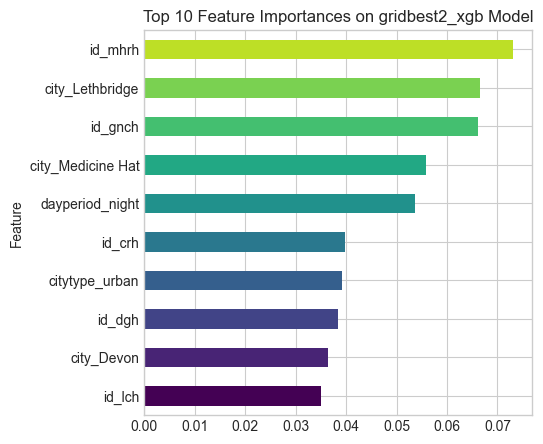

In [253]:
feat_importances = Utility.get_feature_importances_and_plot(gridbest2_xgb, X_train, 'gridbest2_xgb')
display(feat_importances)

Just for this model, which is the best performing model overall, obtain the XGBoost plot of feature importances for Gain and Weight, respectively.

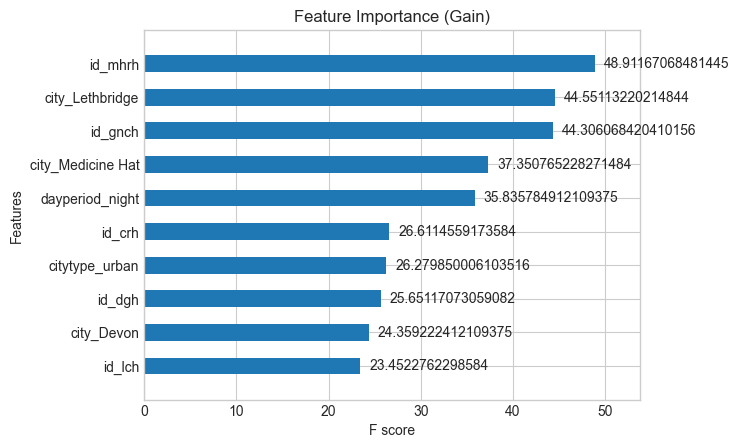

In [274]:
# Show Gain
from xgboost import plot_importance
plot_importance(gridbest2_xgb, max_num_features=10, importance_type='gain', show_values=True, height=0.5, title='Feature Importance (Gain)');

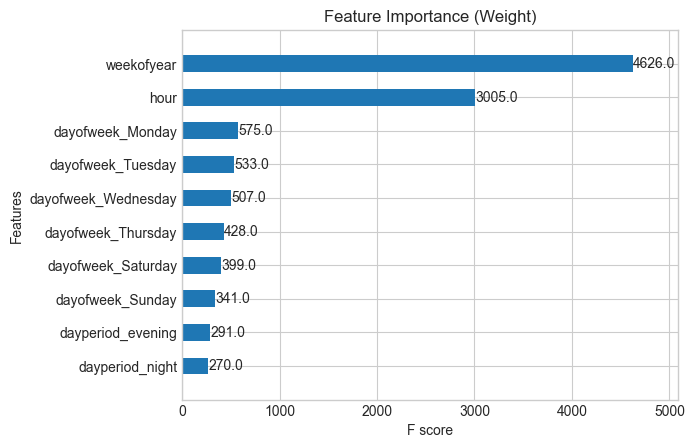

In [275]:
# Show Weight
plot_importance(gridbest2_xgb, max_num_features=10, importance_type='weight', show_values=True, height=0.5, title='Feature Importance (Weight)');

# Rebuild Grid Search Run #3 best model (`gridbest3`) from GridSearchCV run #2 `best_params_`:

Grid Search Run #3 better than the regular non-GridSearch/tuned models, but not better than Grid Search Run #2, and was generated using Google Colab GPU.

We will rebuild it locally to be able to show the comparative scores results on the plots.

Grid Search Run #3 `best_params_`:
```
{'colsample_bytree': 0.7,
 'gamma': 0.3,
 'learning_rate': 0.15,
 'max_depth': 8,
 'reg_lambda': 0.5,
 'scale_pos_weight': 1.5,
 'subsample': 0.8}
```

In [254]:
# Set up string representation of the best_params_ object:
run3_parms_str = """
{'colsample_bytree': 0.7,
 'gamma': 0.3,
 'learning_rate': 0.15,
 'max_depth': 8,
 'reg_lambda': 0.5,
 'scale_pos_weight': 1.5,
 'subsample': 0.8}
"""

# Make the above into a dictionary
run3_parms_dict = eval(run3_parms_str)

# Instantiate an XGBClassifier with the same parameters
gridbest3_xgb = XGBClassifier(random_state=Utility.RANDOM_STATE_CONST, tree_method='hist', **run3_parms_dict)

In [255]:
# Fit the model
gridbest3_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

## Evaluate model performance: "gridbest3"

In [256]:
# Get preds from grid_search.best_estimator_
y_train_pred = gridbest3_xgb.predict(X_train)
y_test_pred = gridbest3_xgb.predict(X_test)

Confusion Matrix

In [257]:
# Confusion Matrix
print("\nResults on TRAINING data:")
gridbest3_train_cm = Utility.print_confusion_matrix_with_labels(y_train, y_train_pred)

print("\nResults on TEST data:")
gridbest3_test_cm = Utility.print_confusion_matrix_with_labels(y_test, y_test_pred)


Results on TRAINING data:


,Predicted Positive,Predicted Negative
Actual Positive,12496,1084
Actual Negative,3125,24035



Results on TEST data:


,Predicted Positive,Predicted Negative
Actual Positive,2145,378
Actual Negative,4311,29552


ROC Curve


Results on TRAINING data:


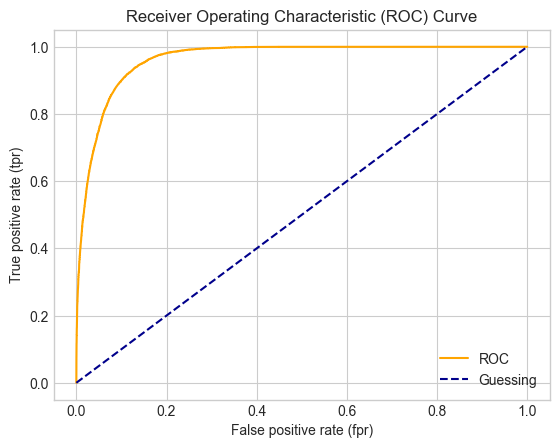


Results on TEST data:


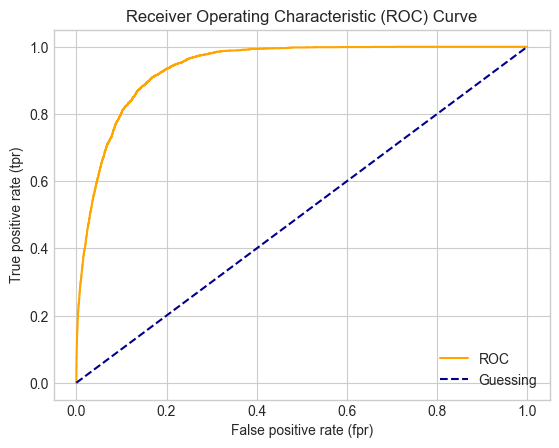

In [258]:
# ROC Curve
print("\nResults on TRAINING data:")
y_train_probs_positive = gridbest3_xgb.predict_proba(X_train)[:,1]
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_probs_positive)
Utility.plot_roc_curve(train_fpr, train_tpr)

print("\nResults on TEST data:")
y_test_probs_positive = gridbest3_xgb.predict_proba(X_test)[:,1]
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_probs_positive)
Utility.plot_roc_curve(test_fpr, test_tpr)

Classification Scores

In [259]:
# Scores
print("\nResults on TRAINING data:")
gridbest3_train_scores = Utility.evaluate_preds(y_train, y_train_pred)

print("\nResults on TEST data:")
gridbest3_test_scores = Utility.evaluate_preds(y_test, y_test_pred)


Results on TRAINING data:
Accuracy            :      89.67%
Precision           :       0.80
Recall              :       0.92
F1 score            :       0.86
F1 (macro) score    :       0.89
F1 (weighted) score :       0.90
ROC-AUC             :       0.90

Results on TEST data:
Accuracy            :      87.11%
Precision           :       0.33
Recall              :       0.85
F1 score            :       0.48
F1 (macro) score    :       0.70
F1 (weighted) score :       0.90
ROC-AUC             :       0.86


Feature Importances

citytype_urban            0.137484
dayperiod_night           0.069571
city_Devon                0.058156
dayperiod_evening         0.056893
id_gnch                   0.052097
id_mhrh                   0.049756
id_crh                    0.044304
id_plc                    0.035210
city_Medicine Hat         0.032071
id_shc                    0.030903
id_dgh                    0.024794
city_Edmonton             0.024549
id_mch                    0.023073
city_Fort Saskatchewan    0.021762
id_lch                    0.021148
id_stollery               0.020961
id_uah                    0.020371
id_nchc                   0.019509
id_rdrh                   0.018264
id_rgh                    0.018167
hour                      0.017355
id_fsch                   0.016599
id_fmc                    0.016340
city_Lethbridge           0.015789
city_Leduc                0.015647
city_St. Albert           0.015437
city_Sherwood Park        0.015031
id_schc                   0.013299
id_rah              

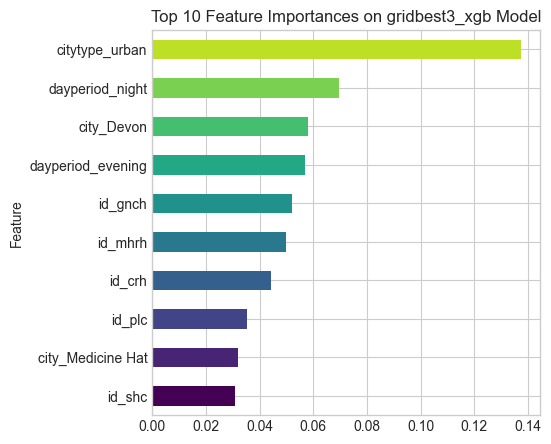

In [260]:
feat_importances = Utility.get_feature_importances_and_plot(gridbest3_xgb, X_train, 'gridbest3_xgb')
display(feat_importances)

# Evaluate performance of:
* Grid Search Run #3 (`gridbest3`) vs.
* Grid Search Run #2 (`gridbest2`) vs.
* the `labelpartialsmote` and
* `baselinesmote` models from before

In [261]:
# Recall that until now, the df_compare dataframe with scores is defined as:
#df_compare = pd.DataFrame({
#    'baseline_train': baseline_train_scores,
#    'baseline_test': baseline_test_scores,
#    'onehot_train': onehot_train_scores,
#    'onehot_test': onehot_test_scores,
#    'onehot_dropdayperiod_train': onehot_dropdayperiod_train_scores,
#    'onehot_dropdayperiod_test': onehot_dropdayperiod_test_scores,
#    'labelencoded_train': labelencoded_train_scores,
#    'labelencoded_test': labelencoded_test_scores,
#    'labelpartial_train': labelpartial_train_scores,
#    'labelpartial_test': labelpartial_test_scores,
#    'labelpartialsmote_train': labelpartialsmote_train_scores,
#    'labelpartialsmote_test': labelpartialsmote_test_scores})
#df_compare['baselinesmote_train'] = baselinesmote_train_scores
#df_compare['baselinesmote_test'] = baselinesmote_test_scores

# Add the Grid Search Run #2 and #3 scores
df_compare['gridbest2_train'] = gridbest2_train_scores
df_compare['gridbest2_test'] = gridbest2_test_scores

df_compare['gridbest3_train'] = gridbest3_train_scores
df_compare['gridbest3_test'] = gridbest3_test_scores
df_compare

,baseline_train,baseline_test,onehot_train,onehot_test,onehot_dropdayperiod_train,onehot_dropdayperiod_test,labelencoded_train,labelencoded_test,labelpartial_train,labelpartial_test,labelpartialsmote_train,labelpartialsmote_test,baselinesmote_train,baselinesmote_test,gridbest2_train,gridbest2_test,gridbest3_train,gridbest3_test
accuracy,0.90,0.88,0.85,0.84,0.84,0.83,0.87,0.86,0.87,0.86,0.89,0.89,0.92,0.89,0.91,0.87,0.90,0.87
precision,0.39,0.35,0.30,0.29,0.28,0.27,0.34,0.32,0.33,0.32,0.83,0.37,0.86,0.38,0.80,0.33,0.80,0.33
recall,0.98,0.85,0.94,0.88,0.93,0.88,0.95,0.89,0.94,0.90,0.86,0.79,0.91,0.78,0.96,0.89,0.92,0.85
f1,0.56,0.49,0.46,0.44,0.43,0.42,0.50,0.47,0.49,0.47,0.84,0.50,0.88,0.51,0.88,0.48,0.86,0.48
f1_macro,0.75,0.71,0.68,0.67,0.67,0.66,0.71,0.70,0.71,0.70,0.88,0.72,0.91,0.72,0.90,0.70,0.89,0.70
f1_weighted,0.92,0.90,0.88,0.88,0.87,0.87,0.90,0.89,0.89,0.89,0.89,0.91,0.92,0.91,0.91,0.89,0.90,0.90
roc_auc,0.94,0.87,0.89,0.86,0.88,0.85,0.91,0.88,0.90,0.88,0.88,0.84,0.92,0.84,0.92,0.88,0.90,0.86


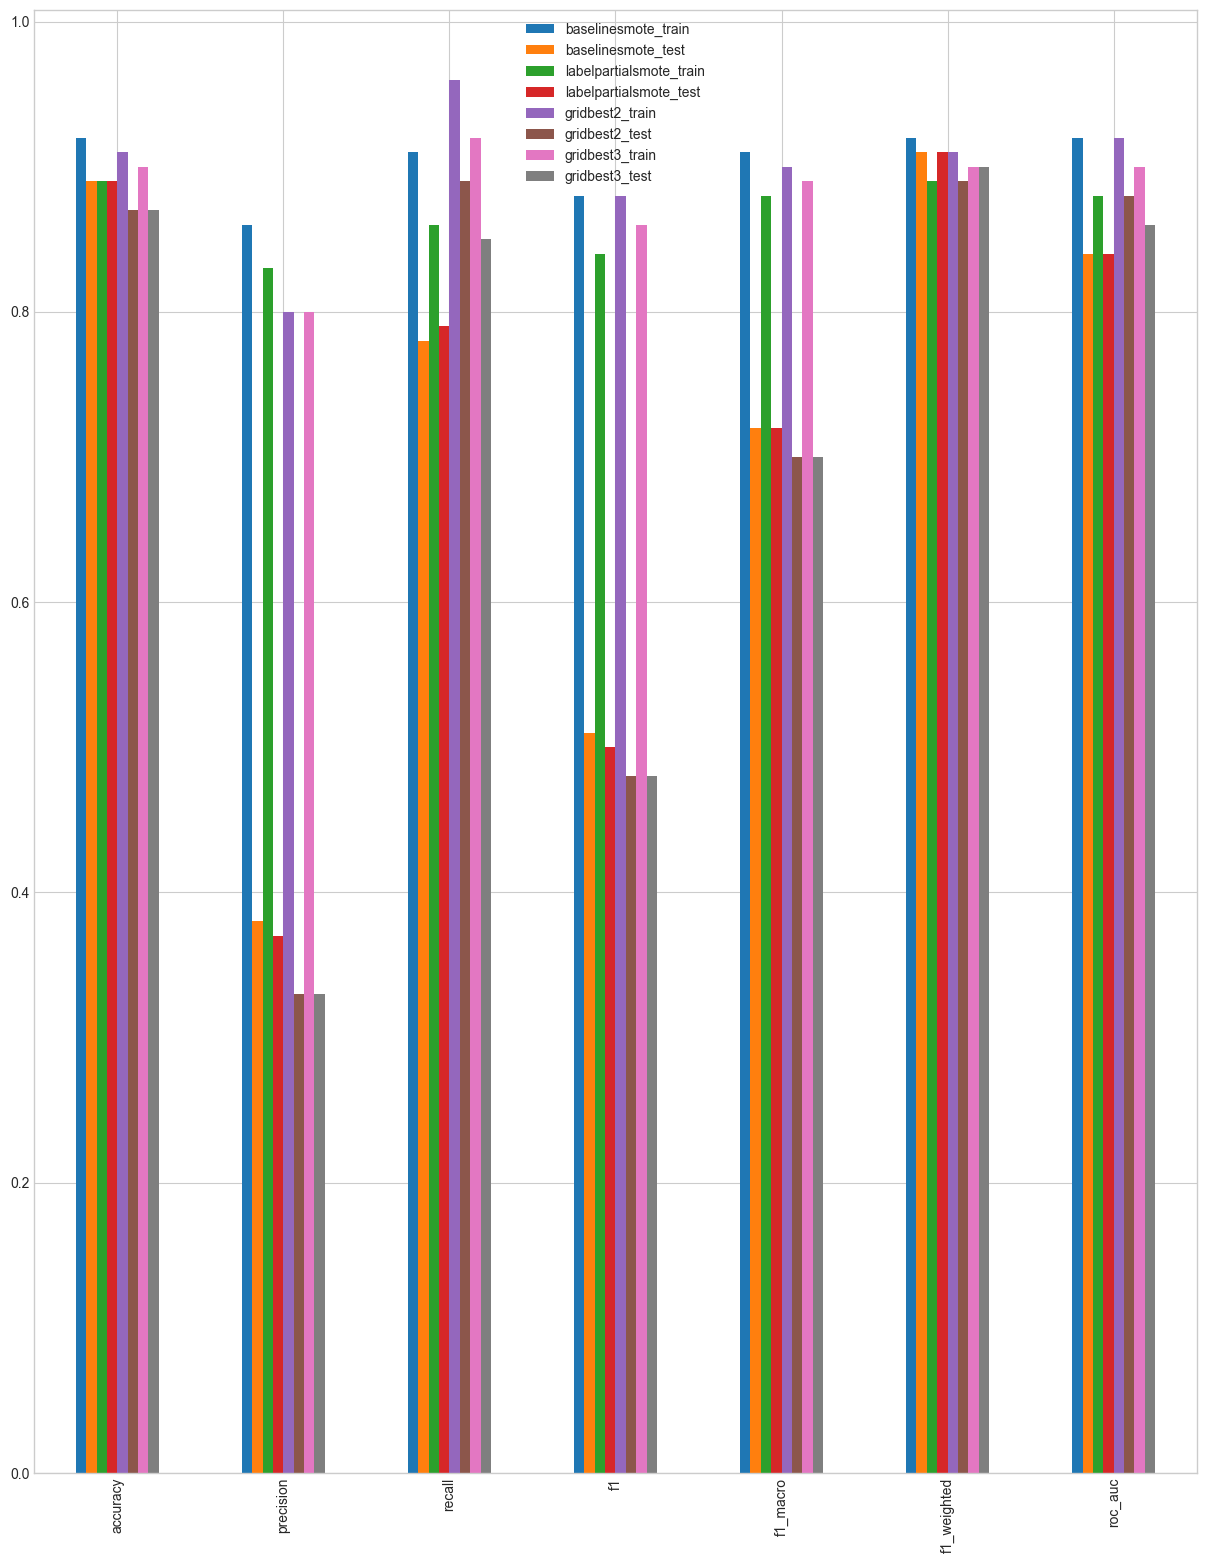

In [262]:
# Plot the scores
sns.set_palette("tab10")
df_compare[['baselinesmote_train', 'baselinesmote_test', 'labelpartialsmote_train', 'labelpartialsmote_test', 'gridbest2_train', 'gridbest2_test', 'gridbest3_train', 'gridbest3_test']].plot.bar(figsize=(15,19));

Draw another graph comparing all scores only against the gridbest_test and labelpartialsmote_test, since those are the ones that matter most (unseen data)

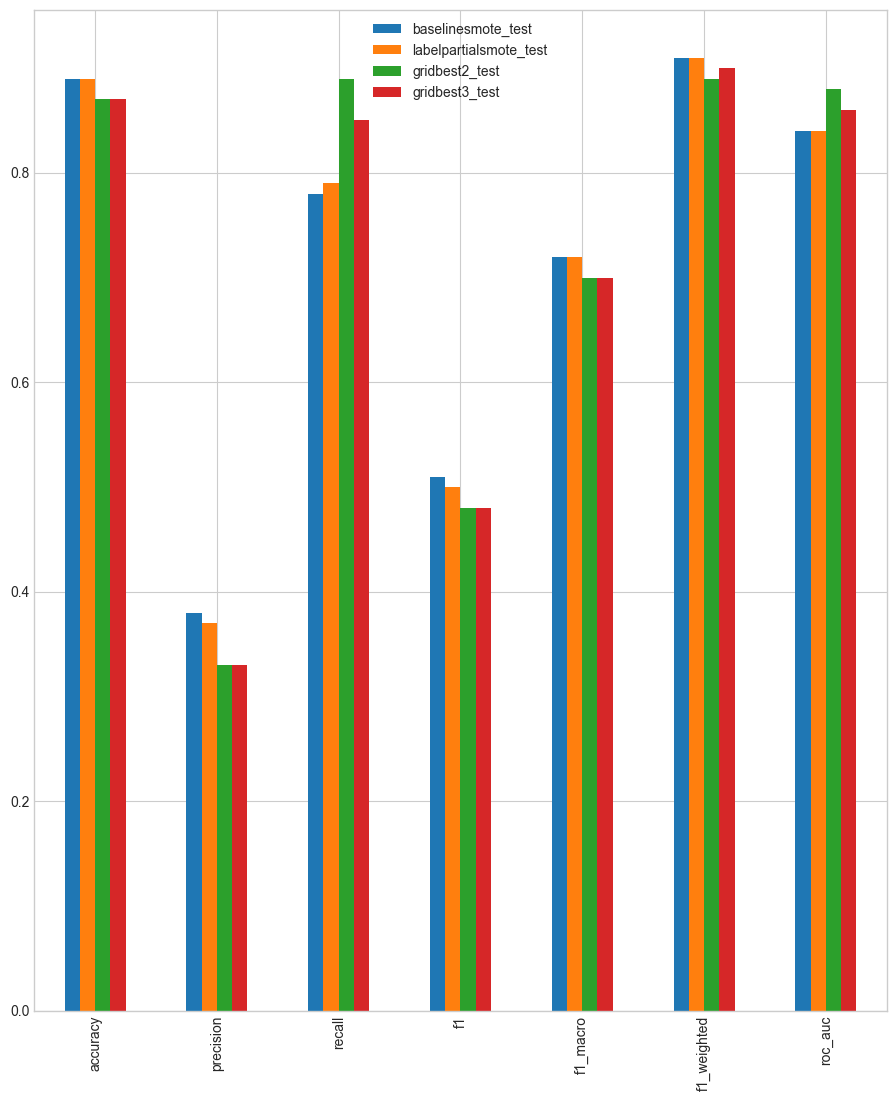

In [263]:
# Plot the scores
sns.set_palette("tab10")
df_compare[['baselinesmote_test', 'labelpartialsmote_test', 'gridbest2_test', 'gridbest3_test']].plot.bar(figsize=(11,13));

See the actual scores compared side by side on balanced_test vs. gridbest_test

In [264]:
df_compare[['baselinesmote_test', 'labelpartialsmote_test', 'gridbest2_test', 'gridbest3_test']]

,baselinesmote_test,labelpartialsmote_test,gridbest2_test,gridbest3_test
accuracy,0.89,0.89,0.87,0.87
precision,0.38,0.37,0.33,0.33
recall,0.78,0.79,0.89,0.85
f1,0.51,0.50,0.48,0.48
f1_macro,0.72,0.72,0.70,0.70
f1_weighted,0.91,0.91,0.89,0.90
roc_auc,0.84,0.84,0.88,0.86


Findings:

* Low Precision score continues to be a challenge, likely mostly because the original data has significant class imbalance (Class 0: 93.3%, Class 1: 6.7%).
* Tradeoff is some models have relatively higher Precision but then lower Recall than other models which have relatively lower Precision.
    * For example, if I was using this model to predict incidence of "long wait" at a given hospital, city, citytype, or month of the year to inform the government about "possible hospitals with relatively 'more' long wait time issues that need to be looked closer at", I might choose the `baselinesmote` model because it has the highest Precision out of all of the models, and meaning that, relatively speaking, it has a lower number of False Positives.  In such a situation, the government may action hospitals or cities where there appears to be a higher incidence of 'long wait' in a month, and there being a lower relative number of False Positives in that model mitigates the potential waste of resources or risk of being alarmist.
    * But if I was doing predictions for 'long wait' for members of the public, I might choose the `gridbest2` model because it has a reasonably high Recall (lower relative number of False Negatives).  That model has a relatively lower Precision score which means there's a greater likelihood (compared to other models) for this model to predict a 'long wait' when there isn't going to be.  In such a situation, the citizen will be pleasantly surprised.  However, the relatively higher Recall score is valuable to the citizen because there is a relatively lower number of False Negatives, where the model predicts there isn't a long wait, and there ends up being a long wait.

# Save the Best Models

Save:
* `baselinesmote`:  The best of the XGBoostClassifier before GridSearch with SMOTE `sampling_strategy` = 0.1, Under `sampling_strategy` = 0.5, useful for cases where we want higher Precision.
* `gridbest2_xgb`:  The best of the XGBoostClassifier with SMOTE `sampling_strategy` = 0.1, Under `sampling_strategy` = 0.5 and best parameters for Grid Search Run #2, overall best and useful for cases where we don't care as much about the relatively lower Precision score.

In [268]:
# # Setup paths and filenames

relativepath = Utility.MODELS_RELATIVE_PATH

#baselinepartialsmote_filename = 'baselinesmote_xgb.pkl'
baselinepartialsmote_filename = 'xgb_baselinesmote.pkl'

#grid_search_best_estimator_filename = 'labelpartialsmote_xgb_grid_search_run2_best_estimator.pkl'
grid_search_best_estimator_filename = 'xgb_grid_search_run2_best_estimator_labelpartialsmote.pkl'

In [269]:
# Write allobjects to disk

with open(relativepath + baselinepartialsmote_filename, 'wb') as f:
    pickle.dump(baselinesmote_xbg, f)

with open(relativepath + grid_search_best_estimator_filename, 'wb') as f:
    pickle.dump(gridbest2_xgb, f)

In [270]:
# Save the df_compare

relativepath = Utility.OUTPUT_RELATIVE_PATH
df_compare.to_csv(relativepath + 'xgb_compare_model_scores.csv')